# Linear Regression

---
### Contents:

1. Problem Statement


2. Imports


3. Load Dataset


4. EDA and Preprocessing
    - 4.1. Missing Value Diagnosis and Treatment
    - 4.2. Distribution Analysis
    - 4.3. Outlier Detection
    - 4.4. Bivariate Analysis


5. Transformations
    - 5.1. Log
    - 5.2. Squared
    - 5.3. Sqrt
    - 5.4. Cuberoor
    

6. Train-Test-Split


7. Linear Regression Diagnostics (LIHN)
    - 5.1. Linearity Assumption
    - 5.2. Independence Assumption
    - 5.3. Homoscedasticity Assumption
    - 5.4. Normality Assumption


8. Conclusion
---

# 1. Problem Statemet

To check if LR works on time series dataset

# 2. Imports

In [198]:
library(stats)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(corrplot)
library(broom)
library(ggpubr)
library(MASS)
library("writexl")
library("readxl")

# 3. Loading Dataset

In [199]:
df_features = read.csv("data/Walmart Retail Data Analytics - Features data-set.csv", sep = ",")
head(df_features)

Store Date       Temperature Fuel_Price MarkDown1 MarkDown2 MarkDown3
1 1     05/02/2010 42.31       2.572      NA        NA        NA       
2 1     12/02/2010 38.51       2.548      NA        NA        NA       
3 1     19/02/2010 39.93       2.514      NA        NA        NA       
4 1     26/02/2010 46.63       2.561      NA        NA        NA       
5 1     05/03/2010 46.50       2.625      NA        NA        NA       
6 1     12/03/2010 57.79       2.667      NA        NA        NA       
  MarkDown4 MarkDown5 CPI      Unemployment IsHoliday
1 NA        NA        211.0964 8.106        FALSE    
2 NA        NA        211.2422 8.106         TRUE    
3 NA        NA        211.2891 8.106        FALSE    
4 NA        NA        211.3196 8.106        FALSE    
5 NA        NA        211.3501 8.106        FALSE    
6 NA        NA        211.3806 8.106        FALSE

Sales data-set.csv

In [28]:
df_sales = read.csv("data/Walmart Retail Data Analytics - sales data-set.csv", sep = ",")
head(df_sales)

Store Dept Date       Weekly_Sales IsHoliday
1 1     1    05/02/2010 24924.50     FALSE    
2 1     1    12/02/2010 46039.49      TRUE    
3 1     1    19/02/2010 41595.55     FALSE    
4 1     1    26/02/2010 19403.54     FALSE    
5 1     1    05/03/2010 21827.90     FALSE    
6 1     1    12/03/2010 21043.39     FALSE

Stores data-set.csv

In [29]:
df_stores = read.csv("data/Walmart Retail Data Analytics - stores data-set.csv", sep = ",")
head(df_stores)

Store Type Size  
1 1     A    151315
2 2     A    202307
3 3     B     37392
4 4     A    205863
5 5     B     34875
6 6     A    202505

### Merging three datasets into file

In [30]:
load_dataset <- function(df_sales, df_features, df_stores) {
    
    df_sales$Date <- as.Date(df_sales$Date, format = "%d/%m/%Y")
    df_sales$Date <- format(df_sales$Date, "%Y-%m-%d")
    df_sales$Date <- as.Date(df_sales$Date, format = "%Y-%m-%d")
    df_sales

    df_features$Date <- as.Date(df_features$Date, format = "%d/%m/%Y")
    df_features$Date <- format(df_features$Date, "%Y-%m-%d")
    df_features$Date <- as.Date(df_features$Date, format = "%Y-%m-%d")
    df_features

    #adf_sales <- df_sales %>%  group_by(Date) %>%  summarize(total_sales = sum(Weekly_Sales)) %>% arrange(Date, decreasing=FALSE)
    #adf_sales

    sales_by_date_store <- aggregate(df_sales$Weekly_Sales, by = list(Store = df_sales$Store, Date = df_sales$Date), sum)
    sales_by_date_store <- sales_by_date_store %>% arrange(Store, decreasing=FALSE)
    colnames(sales_by_date_store)[3] <- "Weekly_Sales"
   
    # Merge the data
    df <- merge(df_features, sales_by_date_store, by = c("Date", "Store"))
    df <- merge(df, df_stores, by = c("Store"))

    #a rrange the data and reset the index
    df <- df[order(df$Store, df$Date),]
    rownames(df) <- NULL

    # Convert to Is  holiday to numeric
    df$Holiday_Flag <- as.numeric(df$IsHoliday)
    
    return(df)
}

In [31]:
df = load_dataset(df_sales, df_features, df_stores)
head(df)

Store Date       Temperature Fuel_Price MarkDown1 MarkDown2 MarkDown3
1 1     2010-02-05 42.31       2.572      NA        NA        NA       
2 1     2010-02-12 38.51       2.548      NA        NA        NA       
3 1     2010-02-19 39.93       2.514      NA        NA        NA       
4 1     2010-02-26 46.63       2.561      NA        NA        NA       
5 1     2010-03-05 46.50       2.625      NA        NA        NA       
6 1     2010-03-12 57.79       2.667      NA        NA        NA       
  MarkDown4 MarkDown5 CPI      Unemployment IsHoliday Weekly_Sales Type Size  
1 NA        NA        211.0964 8.106        FALSE     1643691      A    151315
2 NA        NA        211.2422 8.106         TRUE     1641957      A    151315
3 NA        NA        211.2891 8.106        FALSE     1611968      A    151315
4 NA        NA        211.3196 8.106        FALSE     1409728      A    151315
5 NA        NA        211.3501 8.106        FALSE     1554807      A    151315
6 NA        NA        211.3806 8.106        FALSE     1439542      A    151315
  Holiday_Flag
1 0           
2 1           
3 0           
4 0           
5 0           
6 0

In [32]:
# Export to excel and csv
write_xlsx(df, "data/Preprocessed_Dataset.xlsx")
write.csv(df, "data/Preprocessed_Dataset.csv", row.names=FALSE)

----
----

# 4. Exploratory data analysis and Preprocessinng

Before we model the data, let's first explore the data. We'll first check to see whether there are any missing values in the dataset. Then, we'll take a look at some univariate and bivariate summaries of the data.

Some general requirements for Regression Analytics:

1. Missing Values Treatment: Imputation using mean of features.


2. Distribution Analysis: For checking on skewness (Histograms)


3. Outlier Detection: Detect outliers and either drop them or inlvolve them.


4. Correlation Plot: To measure strength of correlation between variables.


5. Scatter Plot: To measure correlation relationship between Response vs predictor, and among predictors.

In [41]:
# CSV
# df = read.csv("data/Preprocessed_Dataset.csv", sep = ",")
# EXCEL
df = read_excel("data/Preprocessed_Dataset.xlsx")
df$Date <- as.Date(df$Date, format = "%Y-%m-%d")
str(df)

tibble [6,435 × 16] (S3: tbl_df/tbl/data.frame)
 $ Store       : num [1:6435] 1 1 1 1 1 1 1 1 1 1 ...
 $ Date        : Date[1:6435], format: "2010-02-05" "2010-02-12" ...
 $ Temperature : num [1:6435] 42.3 38.5 39.9 46.6 46.5 ...
 $ Fuel_Price  : num [1:6435] 2.57 2.55 2.51 2.56 2.62 ...
 $ MarkDown1   : num [1:6435] NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown2   : num [1:6435] NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown3   : num [1:6435] NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown4   : num [1:6435] NA NA NA NA NA NA NA NA NA NA ...
 $ MarkDown5   : num [1:6435] NA NA NA NA NA NA NA NA NA NA ...
 $ CPI         : num [1:6435] 211 211 211 211 211 ...
 $ Unemployment: num [1:6435] 8.11 8.11 8.11 8.11 8.11 ...
 $ IsHoliday   : logi [1:6435] FALSE TRUE FALSE FALSE FALSE FALSE ...
 $ Weekly_Sales: num [1:6435] 1643691 1641957 1611968 1409728 1554807 ...
 $ Type        : chr [1:6435] "A" "A" "A" "A" ...
 $ Size        : num [1:6435] 151315 151315 151315 151315 151315 ...
 $ Holiday_Flag

In [42]:
dim(df)

[1] 6435   16

In [43]:
numerical_cols = c('Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 
                   'CPI', 'Unemployment', 'Weekly_Sales', 'Size')

In [44]:
original_rows = nrow(df)
summary(df)

     Store         Date             Temperature       Fuel_Price   
 Min.   : 1   Min.   :2010-02-05   Min.   : -2.06   Min.   :2.472  
 1st Qu.:12   1st Qu.:2010-10-08   1st Qu.: 47.46   1st Qu.:2.933  
 Median :23   Median :2011-06-17   Median : 62.67   Median :3.445  
 Mean   :23   Mean   :2011-06-17   Mean   : 60.66   Mean   :3.359  
 3rd Qu.:34   3rd Qu.:2012-02-24   3rd Qu.: 74.94   3rd Qu.:3.735  
 Max.   :45   Max.   :2012-10-26   Max.   :100.14   Max.   :4.468  
                                                                   
   MarkDown1          MarkDown2          MarkDown3           MarkDown4       
 Min.   :    0.27   Min.   :  -265.8   Min.   :   -29.10   Min.   :    0.22  
 1st Qu.: 1679.19   1st Qu.:    37.2   1st Qu.:     4.70   1st Qu.:  483.27  
 Median : 4972.59   Median :   187.0   Median :    22.70   Median : 1419.42  
 Mean   : 6855.59   Mean   :  3219.0   Mean   :  1349.85   Mean   : 3303.86  
 3rd Qu.: 8873.58   3rd Qu.:  1785.3   3rd Qu.:    99.99   3rd Qu.

### 4.1. Missing data

Are there any missing values coded as NA? Or, are there any odd values for variables, e.g., 9999 or 0 possibly standing in for a missing value?

In [45]:
# Count missing values:

missing_values <- sapply(df, function(x) sum(is.na(x)))
print(missing_values)

       Store         Date  Temperature   Fuel_Price    MarkDown1    MarkDown2 
           0            0            0            0         4155         4798 
   MarkDown3    MarkDown4    MarkDown5          CPI Unemployment    IsHoliday 
        4389         4470         4140            0            0            0 
Weekly_Sales         Type         Size Holiday_Flag 
           0            0            0            0 


In [46]:
##### Missing Value Treatment ######

# If there were missing values, imputation with MEAN is a good option for LR!
df$MarkDown1[is.na(df$MarkDown1)] = 0
df$MarkDown2[is.na(df$MarkDown2)] = 0
df$MarkDown3[is.na(df$MarkDown3)] = 0
df$MarkDown4[is.na(df$MarkDown4)] = 0
df$MarkDown5[is.na(df$MarkDown5)] = 0

# Dropping rows where Weakly Sales are negative
df = subset(df, df$Weekly_Sales>=0)

cat("Number of Records:\n\nOriginal Dataset = ", original_rows, "\nProcessed Dataset = ", nrow(df))

Number of Records:

Original Dataset =  6435 
Processed Dataset =  6435

In [48]:
# Count missing values again!

missing_values <- sapply(df, function(x) sum(is.na(x)))
print(missing_values)

       Store         Date  Temperature   Fuel_Price    MarkDown1    MarkDown2 
           0            0            0            0            0            0 
   MarkDown3    MarkDown4    MarkDown5          CPI Unemployment    IsHoliday 
           0            0            0            0            0            0 
Weekly_Sales         Type         Size Holiday_Flag 
           0            0            0            0 


- No missing values in any of the signficant features

### 4.2. Distribution Analysis

#### Histograms

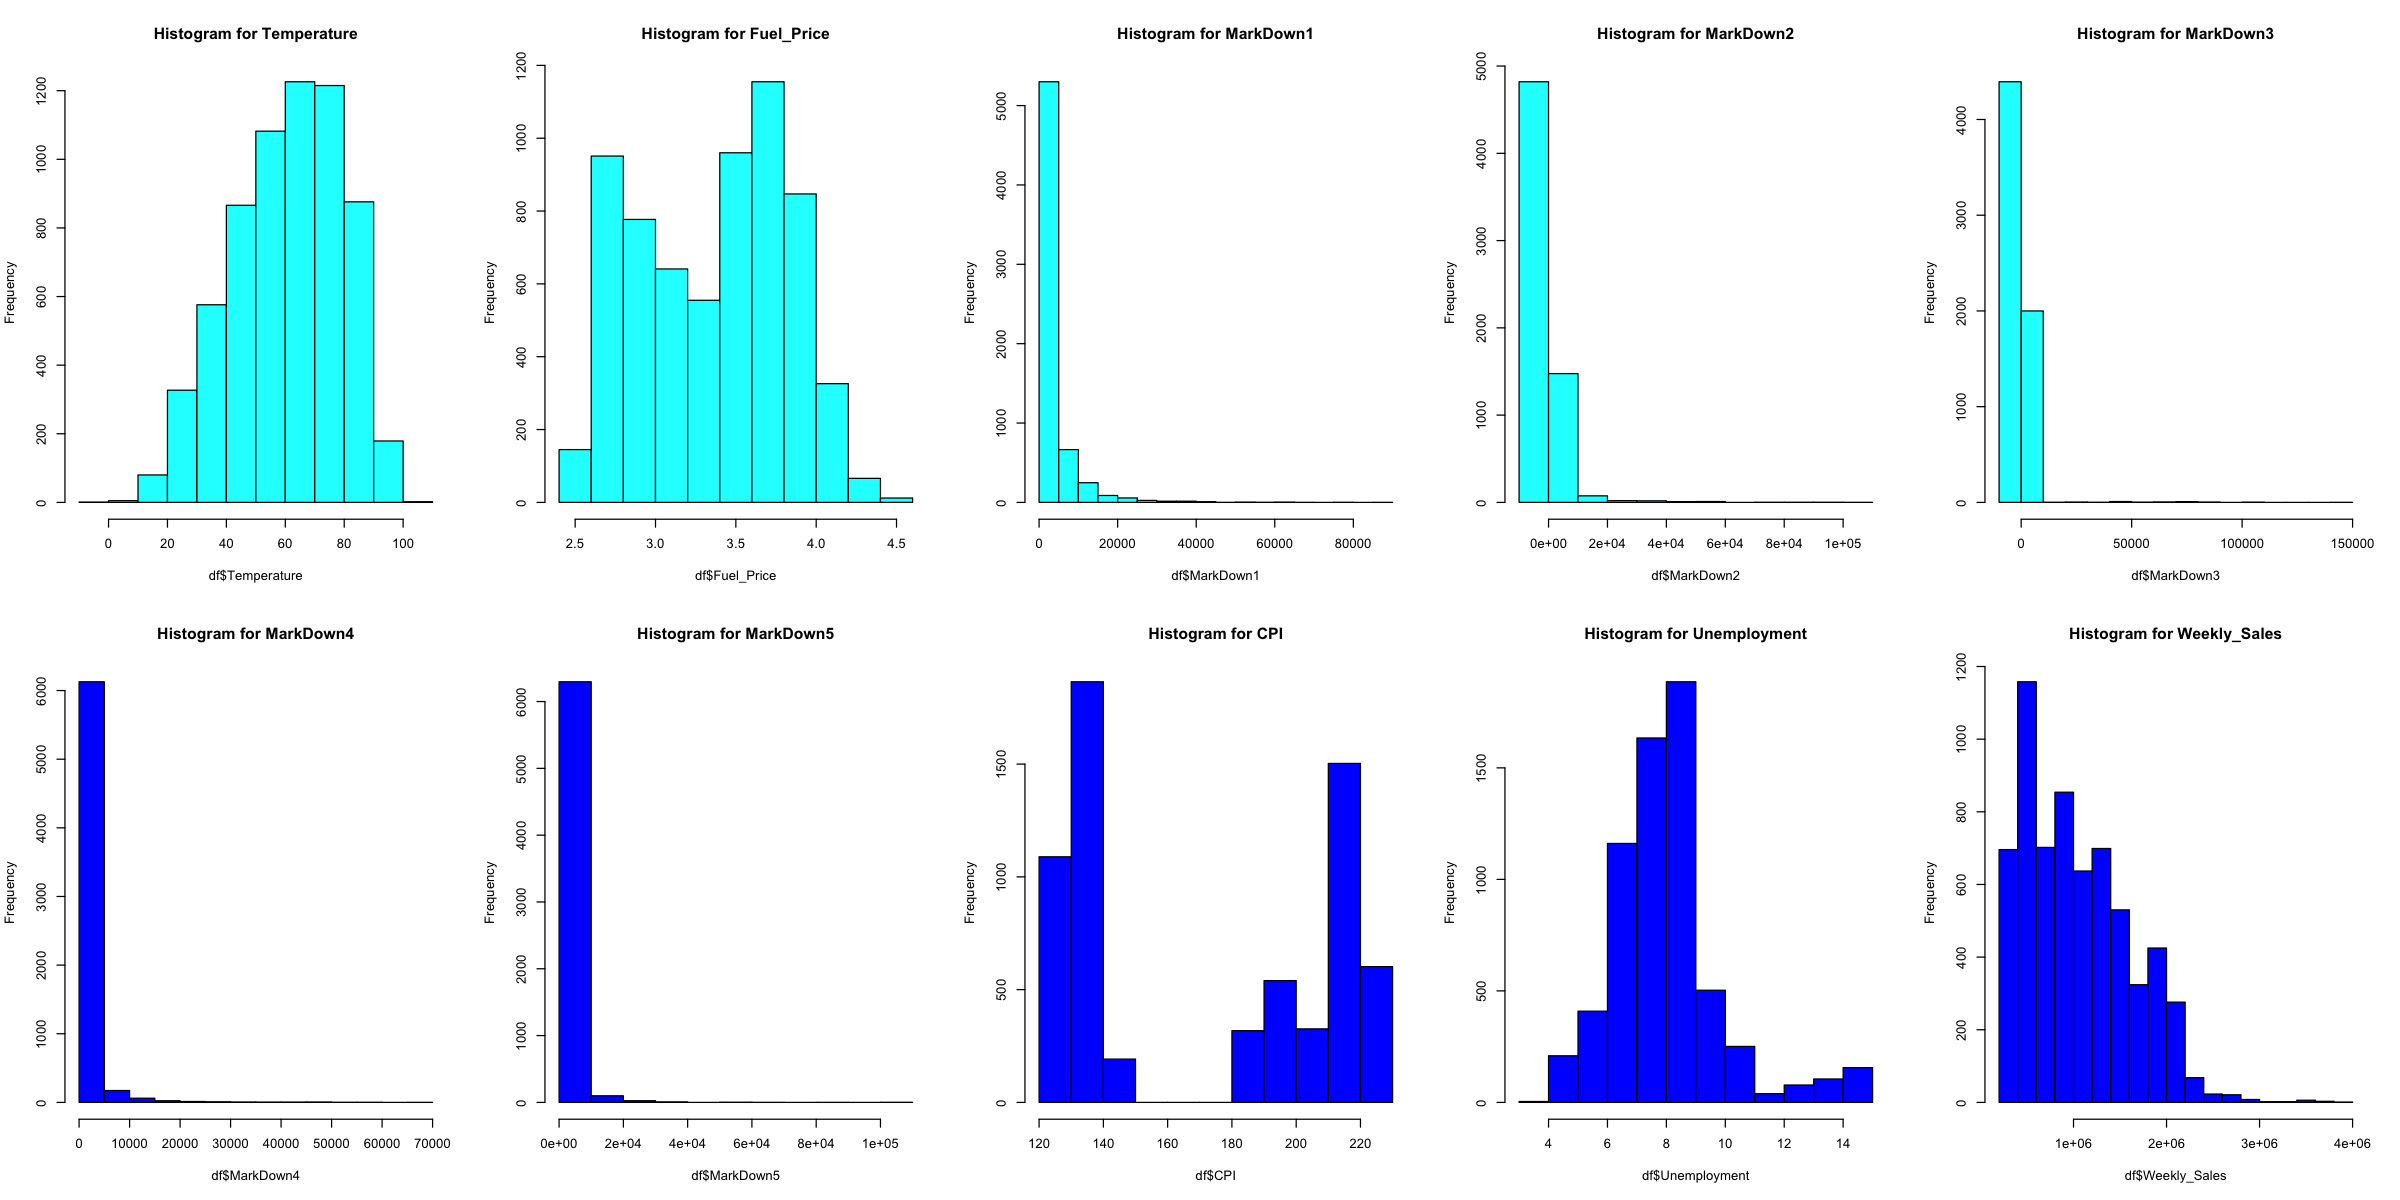

In [49]:
options(repr.plot.width = 20, repr.plot.height = 10)
par(mfrow = c(2, 5))

hist(df$Temperature, col="cyan", main = "Histogram for Temperature")
hist(df$Fuel_Price , col="cyan", main = "Histogram for Fuel_Price")
hist(df$MarkDown1 , col="cyan", main = "Histogram for MarkDown1")
hist(df$MarkDown2 , col="cyan", main = "Histogram for MarkDown2")
hist(df$MarkDown3 , col="cyan", main = "Histogram for MarkDown3")
hist(df$MarkDown4 , col="blue", main = "Histogram for MarkDown4")
hist(df$MarkDown5 , col="blue", main = "Histogram for MarkDown5")
hist(df$CPI , col="blue", main = "Histogram for CPI")
hist(df$Unemployment, col="blue", main = "Histogram for Unemployment")
hist(df$Weekly_Sales, col="blue", main = "Histogram for Weekly_Sales")

- Most of the features appear skewed with exception of `Unemployment`.

### 4.3. Outlier Detection and Treatment

#### Boxplots

As you may have noticed from the histogram of `newspaper`, there may be a few **outliers**. Let's look at some boxplots to see in further detail. Note that R classifies potential outliers by the "IQR criterion". 

This criterion means that all observations above $q_{0.75}+1.5\times IQR$ or below $q_{0.25}-1.5\times IQR$ are classified as outliers, where

$q_{0.25}$ is the first quartile;

$q_{0.75}$ is the third quartile.

IQR is the interquartile range, defined as the difference between the third and first quartile.

A boxplot will "flag" the outliers. Construct a boxplot for each variable and comment on the existence of potential outliers.

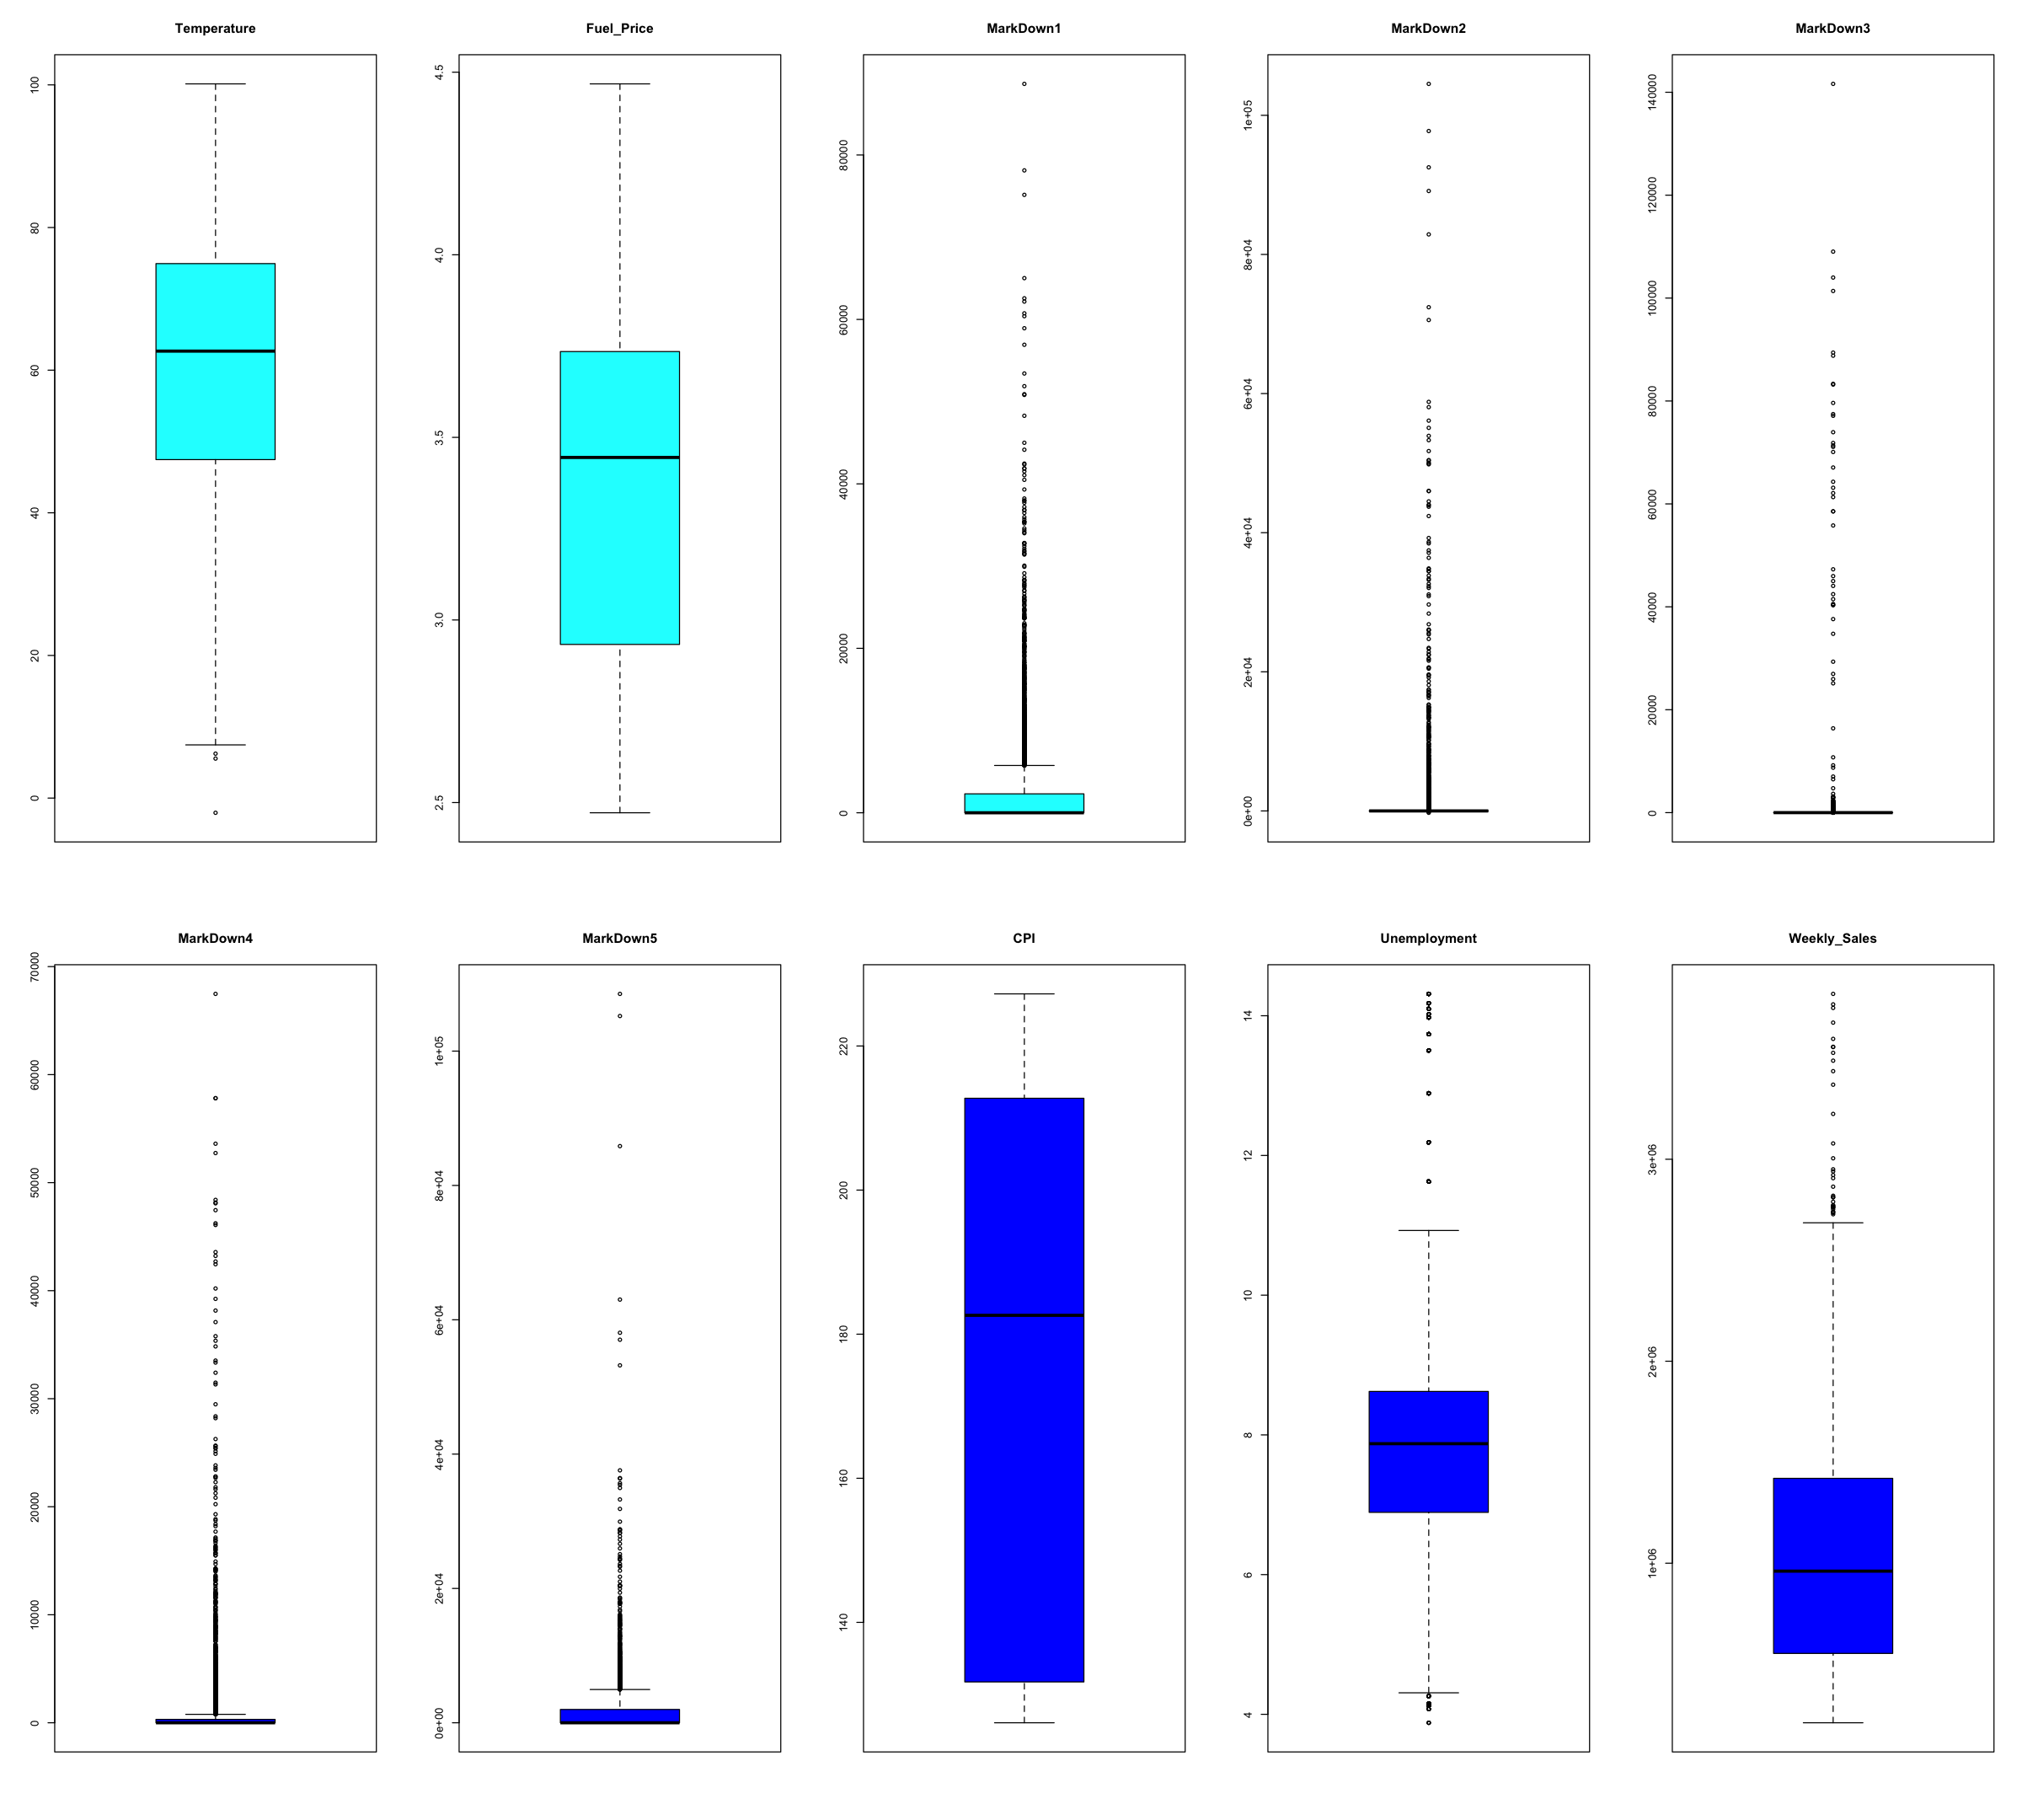

In [50]:
options(repr.plot.width = 20, repr.plot.height = 18)
par(mfrow = c(2, 5))

boxplot(df$Temperature, col="cyan", main = "Temperature")
boxplot(df$Fuel_Price , col="cyan", main = "Fuel_Price")
boxplot(df$MarkDown1 , col="cyan", main = "MarkDown1")
boxplot(df$MarkDown2 , col="cyan", main = "MarkDown2")
boxplot(df$MarkDown3 , col="cyan", main = "MarkDown3")
boxplot(df$MarkDown4 , col="blue", main = "MarkDown4")
boxplot(df$MarkDown5 , col="blue", main = "MarkDown5")
boxplot(df$CPI , col="blue", main = "CPI")
boxplot(df$Unemployment, col="blue", main = "Unemployment")
boxplot(df$Weekly_Sales, col="blue", main = "Weekly_Sales")

As we know, any value

- above Quartile_3 + 1.5IQR or lower than Quartile_1 - 1.5IQR could be classified as an outlier

#### Outlier Treatment

In [51]:
# Weakly Sales
Weekly_Sales_zscores <- scale(df$Weekly_Sales)
outliers <- which(abs(Weekly_Sales_zscores) > 3)
df$Weekly_Sales[outliers] <- mean(df$Weekly_Sales)

# Temperature
Temperature_zscores <- scale(df$Temperature)
outliers <- which(abs(Temperature_zscores) > 3)
df$Temperature[outliers] <- mean(df$Temperature)

# Fuel_Price
Fuel_Price_zscores <- scale(df$Fuel_Price)
outliers <- which(abs(Fuel_Price_zscores) > 3)
df$Fuel_Price[outliers] <- mean(df$Fuel_Price)

# MarkDown
MarkDown1_zscores <- scale(df$MarkDown1)
outliers <- which(abs(MarkDown1_zscores) > 3)
df$MarkDown1[outliers] <- mean(df$MarkDown1)

MarkDown2_zscores <- scale(df$MarkDown2)
outliers <- which(abs(MarkDown2_zscores) > 3)
df$MarkDown2[outliers] <- mean(df$MarkDown2)

MarkDown3_zscores <- scale(df$MarkDown3)
outliers <- which(abs(MarkDown3_zscores) > 3)
df$MarkDown3[outliers] <- mean(df$MarkDown3)

MarkDown4_zscores <- scale(df$MarkDown4)
outliers <- which(abs(MarkDown4_zscores) > 3)
df$MarkDown4[outliers] <- mean(df$MarkDown4)

MarkDown5_zscores <- scale(df$MarkDown5)
outliers <- which(abs(MarkDown5_zscores) > 3)
df$MarkDown5[outliers] <- mean(df$MarkDown5)

# CPI
CPI_zscores <- scale(df$CPI)
outliers <- which(abs(CPI_zscores) > 3)
df$CPI[outliers] <- mean(df$CPI)

# Unemployment
Unemployment_zscores <- scale(df$Unemployment)
outliers <- which(abs(Unemployment_zscores) > 3)
df$Unemployment[outliers] <- mean(df$Unemployment)

### 4.4. Bivariate explorations

Let's now explore how the variables may or may not relate to each other. First, calculate the correlations between variables. Correlations can help us meaasure the strength of the linear relationship between variables. The bland way to do this is with to cor() function.

#### Correlation Plots

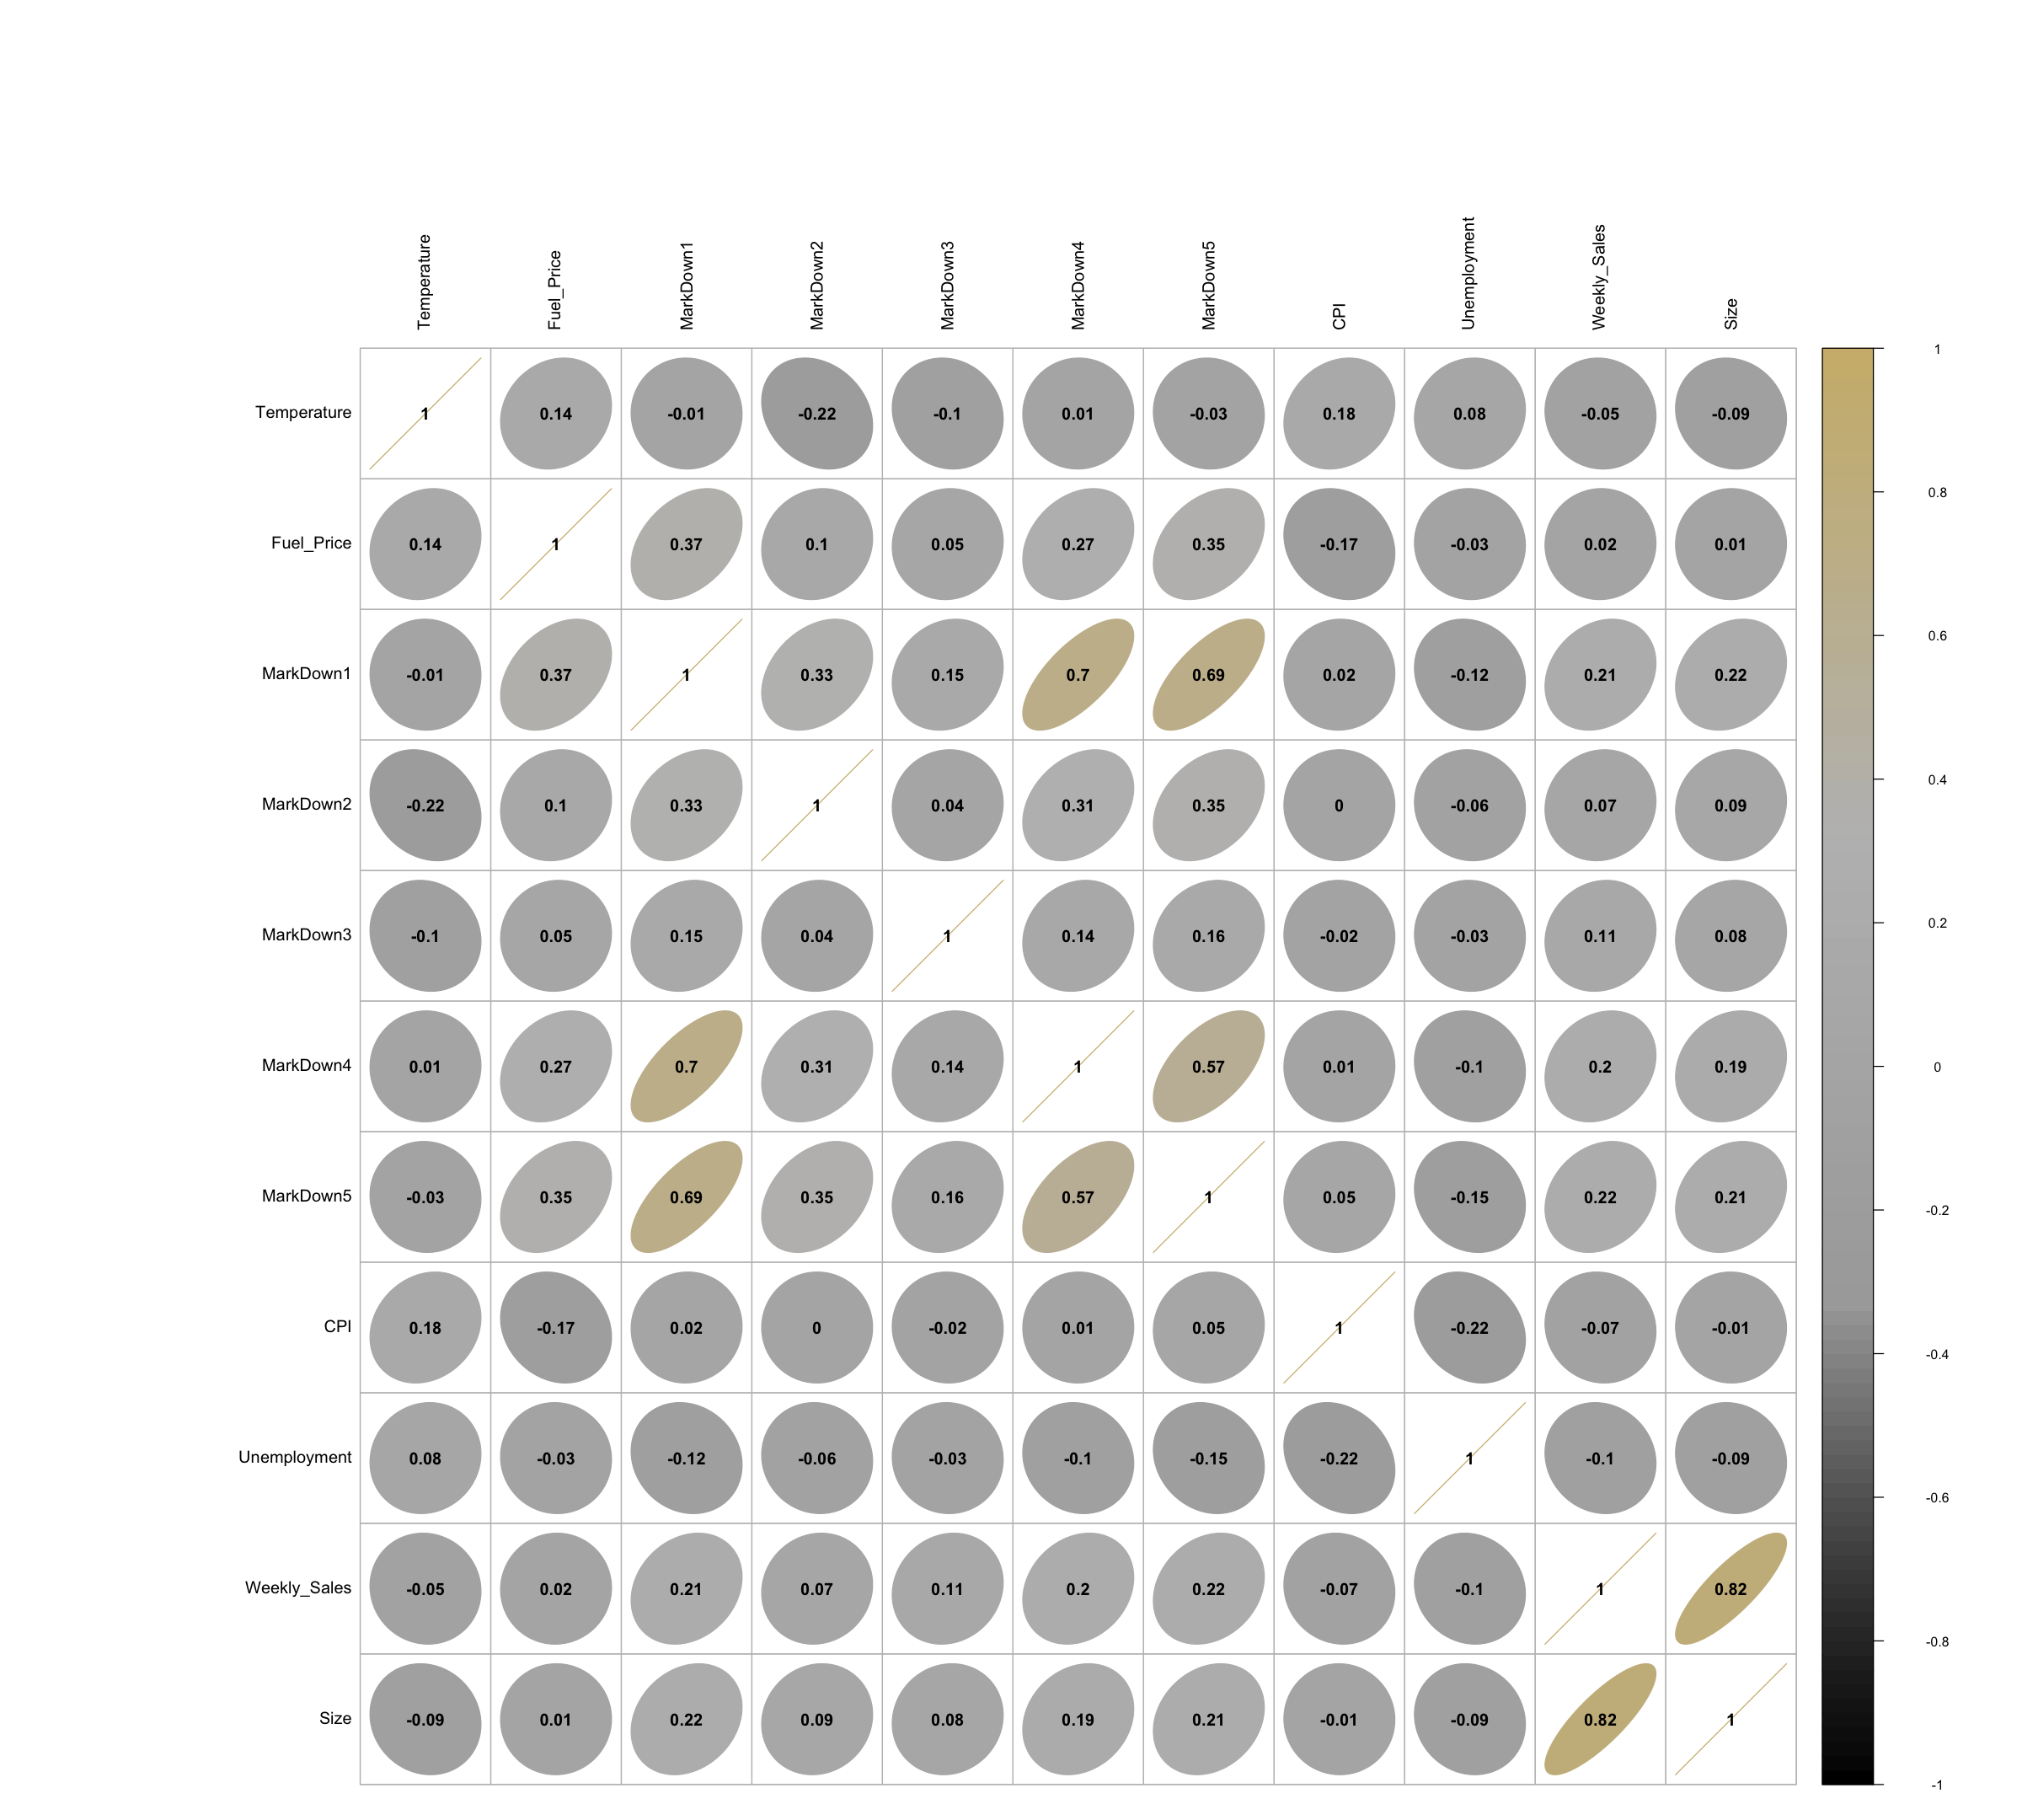

In [52]:
col4 = colorRampPalette(c("black", "darkgrey", "grey","#CFB87C"))
corrplot(cor(df[numerical_cols]), method = "ellipse", col = col4(100),  addCoef.col = "black", tl.col = "black")

#### Average Weakly Sales

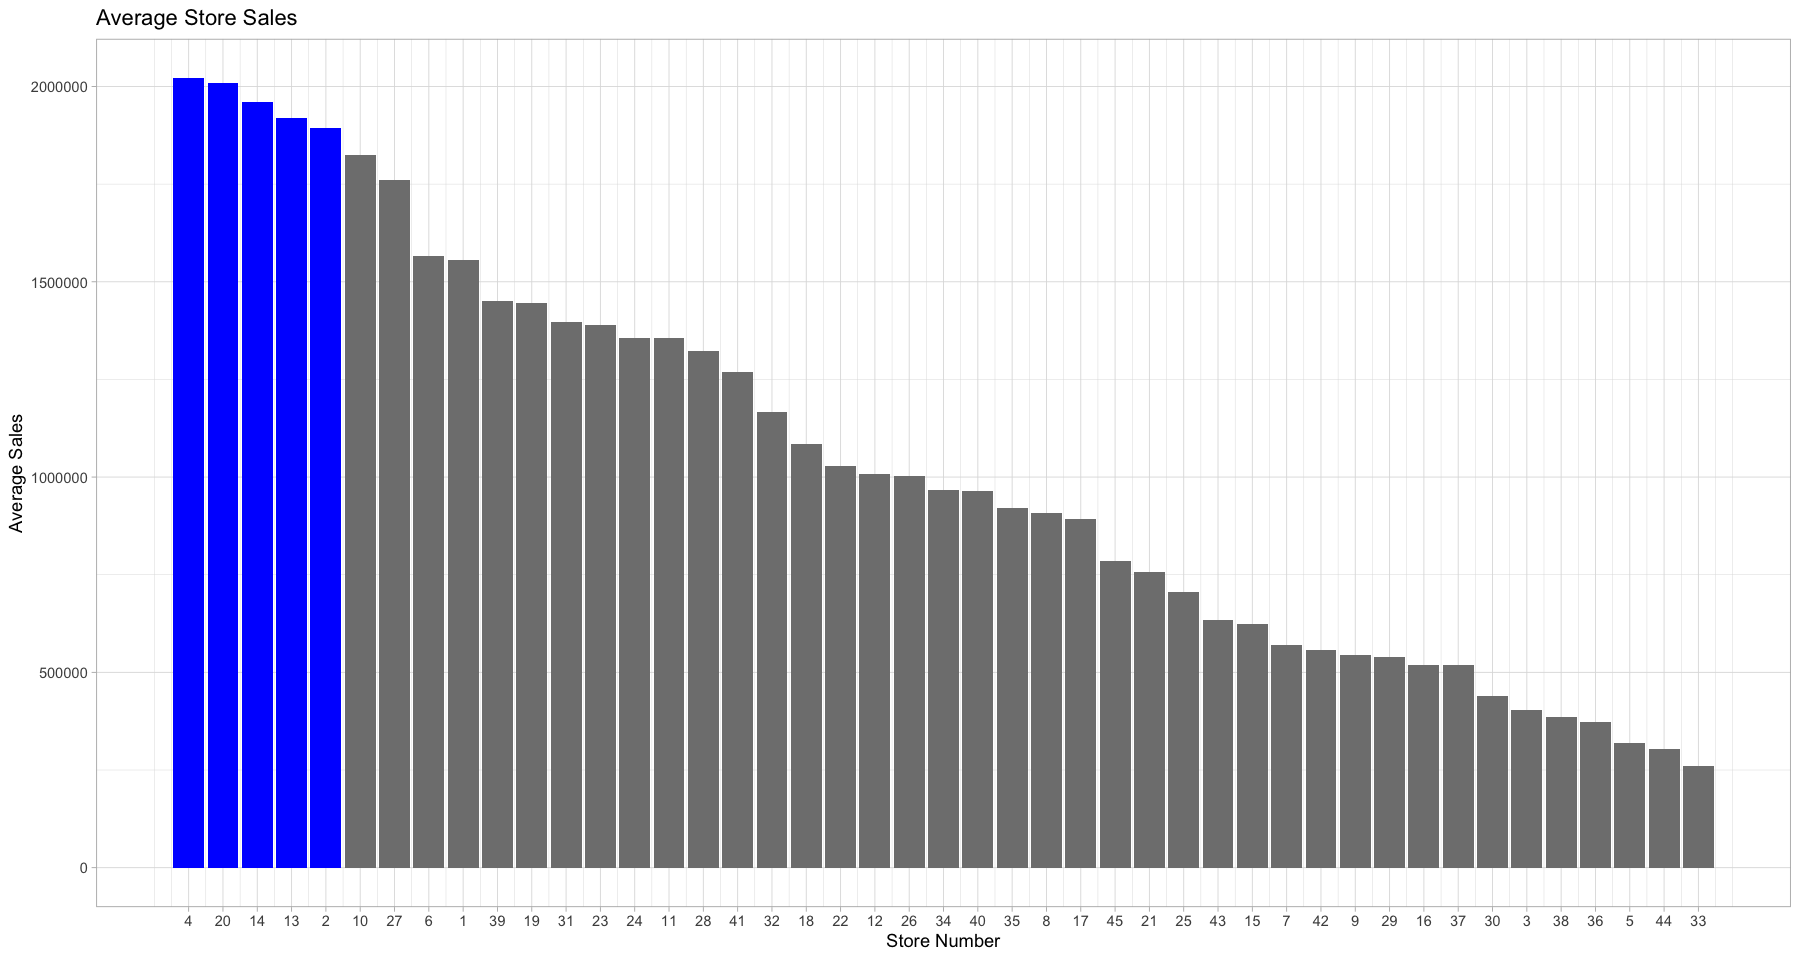

In [58]:
options(repr.plot.width = 15, repr.plot.height = 8)

avg_store_sales <- aggregate(df$Weekly_Sales, by=list(df$Store), FUN=mean)
colnames(avg_store_sales) <- c("Store", "AverageSales")

# Sort the data frame by average sales in descending order
avg_store_sales <- avg_store_sales[order(avg_store_sales$AverageSales, decreasing=TRUE),]
avg_store_sales$colour = c(rep("1", 5), rep("0", 40))

# Create a bar plot
ggplot(avg_store_sales, aes(x=sort(Store, decreasing = FALSE), y=sort(AverageSales, decreasing = TRUE), fill=colour)) +
  geom_bar(stat="identity") +
  ylab("Average Sales") +
  ggtitle("Average Store Sales") + 
  scale_x_continuous("Store Number", labels = as.character(avg_store_sales$Store), breaks = sort(avg_store_sales$Store)) + 
  scale_fill_manual( values = c("1"="blue"), guide=FALSE) + 
  theme_light()

In [59]:
# Selected top 5 stores
df = subset(df, df$Store %in% c(avg_store_sales$Store[1:5]))
df = df[-c(14)] # type is same for top 5 stores

# reset_index
row.names(df) <- NULL

cat("Dimensions: ", dim(df))

Dimensions:  715 15

#### Scatter Pairplots

However, knowing correlations alone isn't enough; the correlation coefficient can be misleading if there are nonlinear relationships, and so we should explore the relationships further.

To do so, we'll look at pairwise scatter plots, i.e., a scatter plot of each variable with each other variable. We should be looking for:

- Relationships between the response and each predictor.
- Relationships between predictor variables. Such relationships are undesirable.

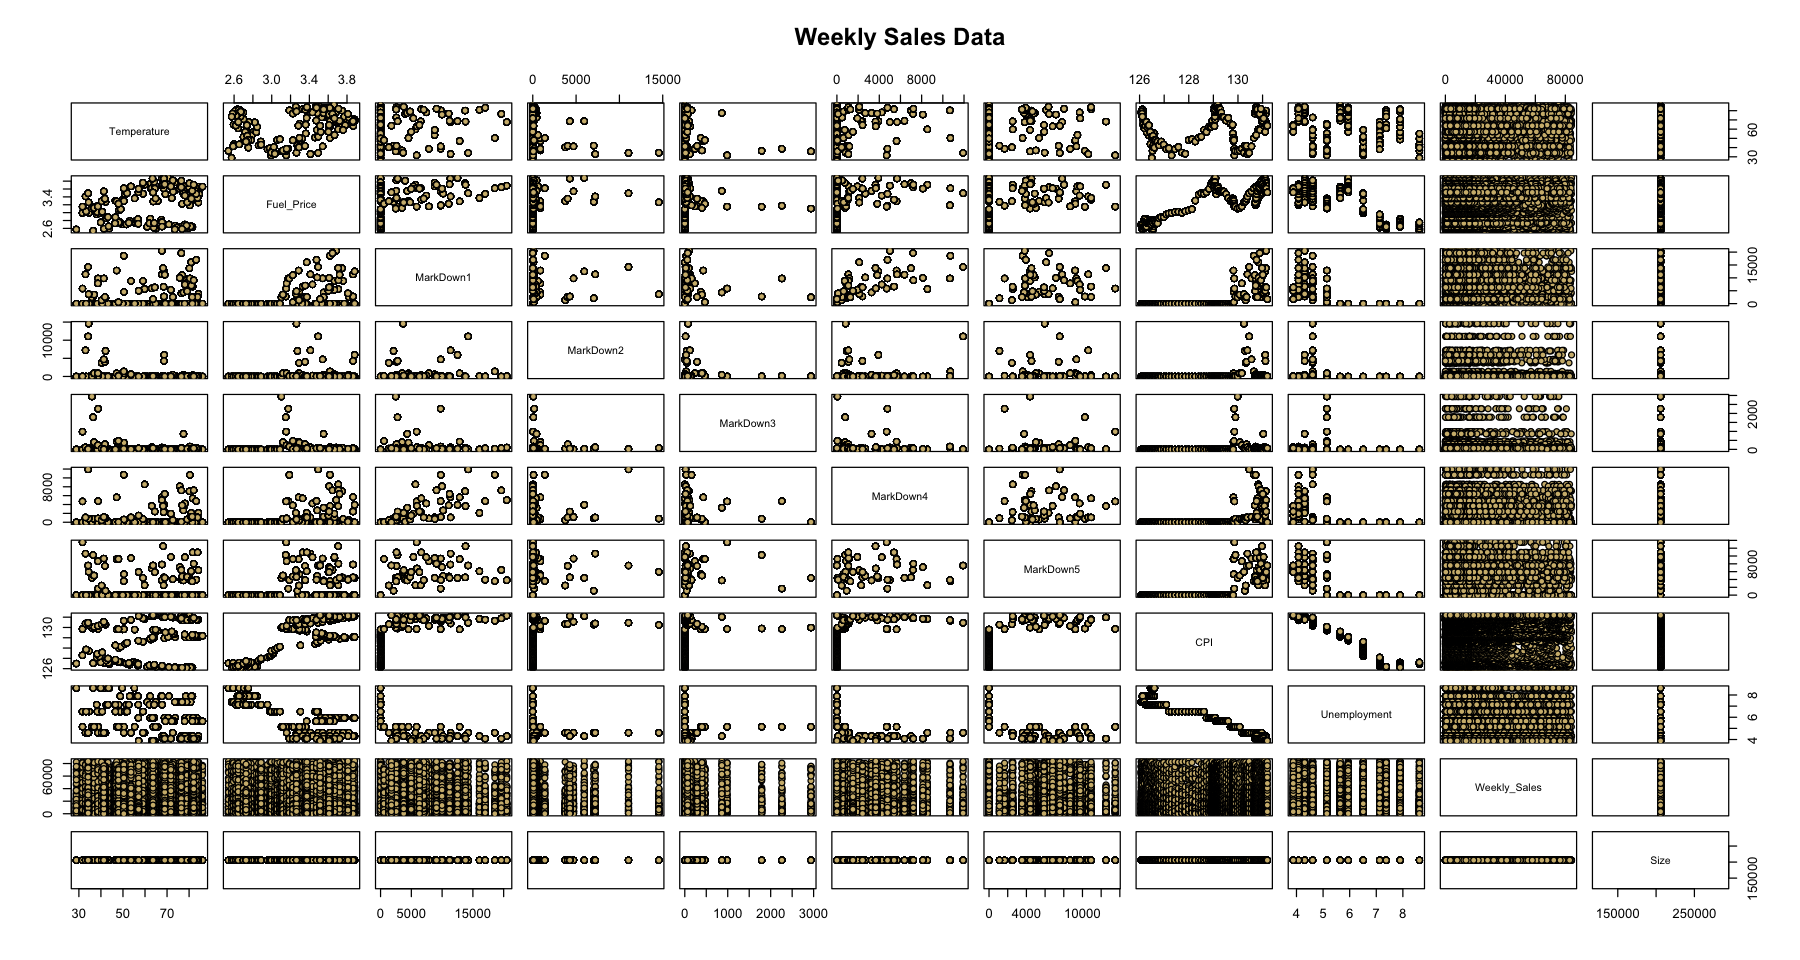

In [66]:
options(repr.plot.width = 15, repr.plot.height = 8)
pairs(df[numerical_cols], main="Weekly Sales Data", pch=21,  bg=c("#CFB87C"))

#### Exploring the effect of Holiday on Weakly Sales

In [64]:
# ggplot(df, aes(x = Dept, y = Weekly_Sales))+ 
#   geom_jitter(aes(colour = IsHoliday)) + 
#   xlab('Dept Number') +
#   ylab('Sales Per Week') +
#   ggtitle("Store Weekly Sales - Comparing the Effect of Holiday") + 
#   theme(
#     legend.position = c(.95, .95),
#     legend.justification = c("right", "top"),
#     legend.box.just = "right",
#     legend.margin = margin(6, 6, 6, 6)
#   )

----
----

# 5. Transformations

Warning message in log(value):
“NaNs produced”
Warning message in log(value):
“NaNs produced”
Warning message:
“Removed 3016 rows containing non-finite values (`stat_bin()`).”


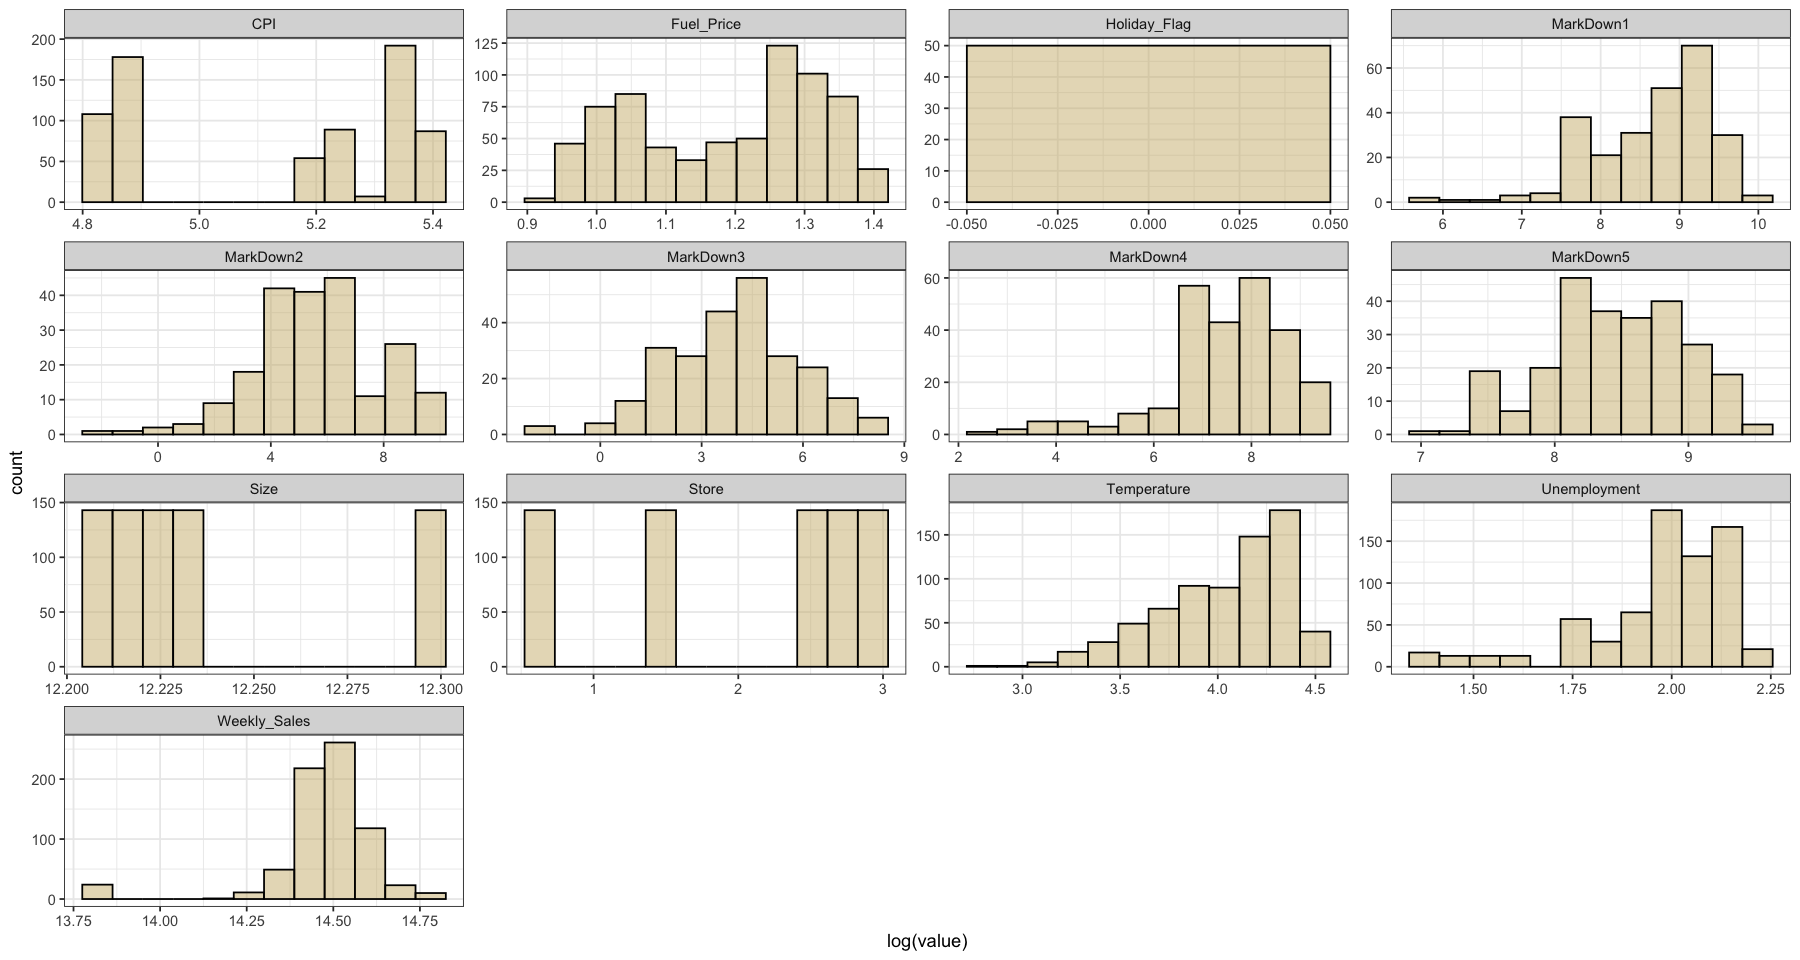

In [116]:
# Log transformation

df %>% 
keep(is.numeric) %>%        # For choosing only numeric variables
gather()%>%                 # Gathering the data
ggplot(aes(log(value)))+
facet_wrap(~key, scales="free")+
geom_histogram(bins=12, color="black", fill="#CFB87C", alpha=0.5) + 
theme_bw()

Warning message in sqrt(value):
“NaNs produced”
Warning message in sqrt(value):
“NaNs produced”
Warning message:
“Removed 3 rows containing non-finite values (`stat_bin()`).”


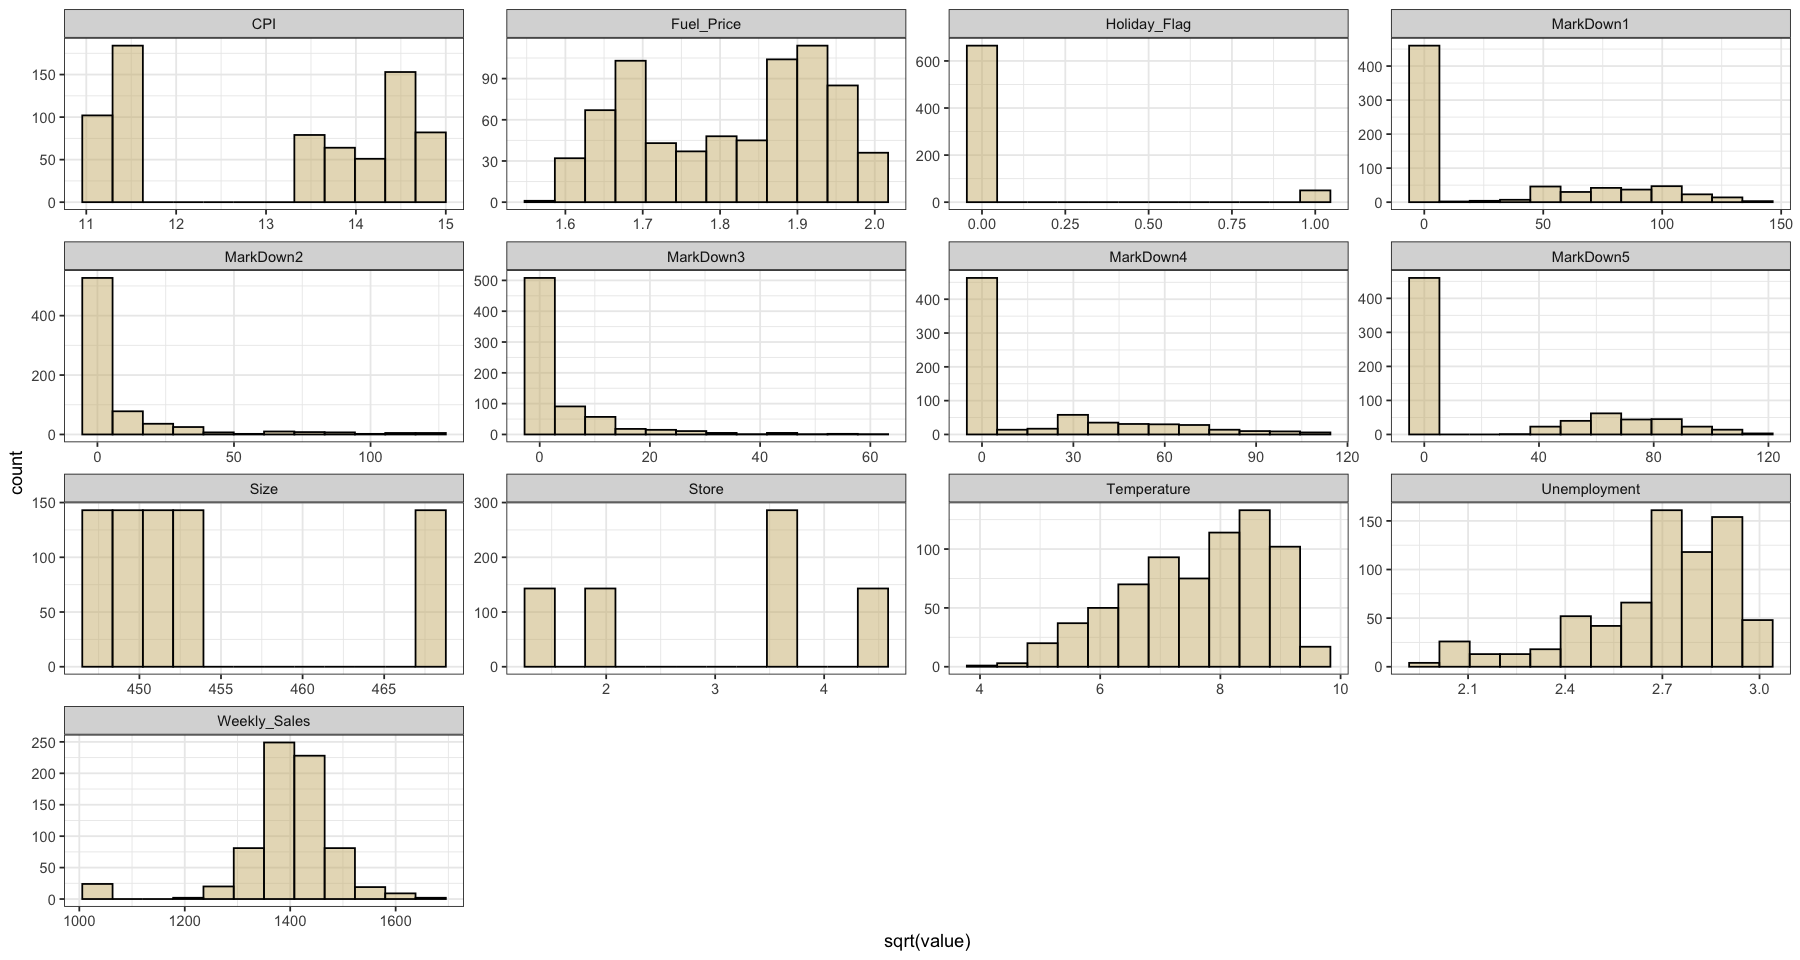

In [73]:
# Squareroot Transformed

df %>% 
keep(is.numeric) %>%    #For choosing only numeric variables
gather()%>%             #Gathering the data
ggplot(aes(sqrt(value)))+
facet_wrap(~key, scales="free")+
geom_histogram(bins=12, color="black", fill="#CFB87C", alpha=0.5)+
theme_bw()

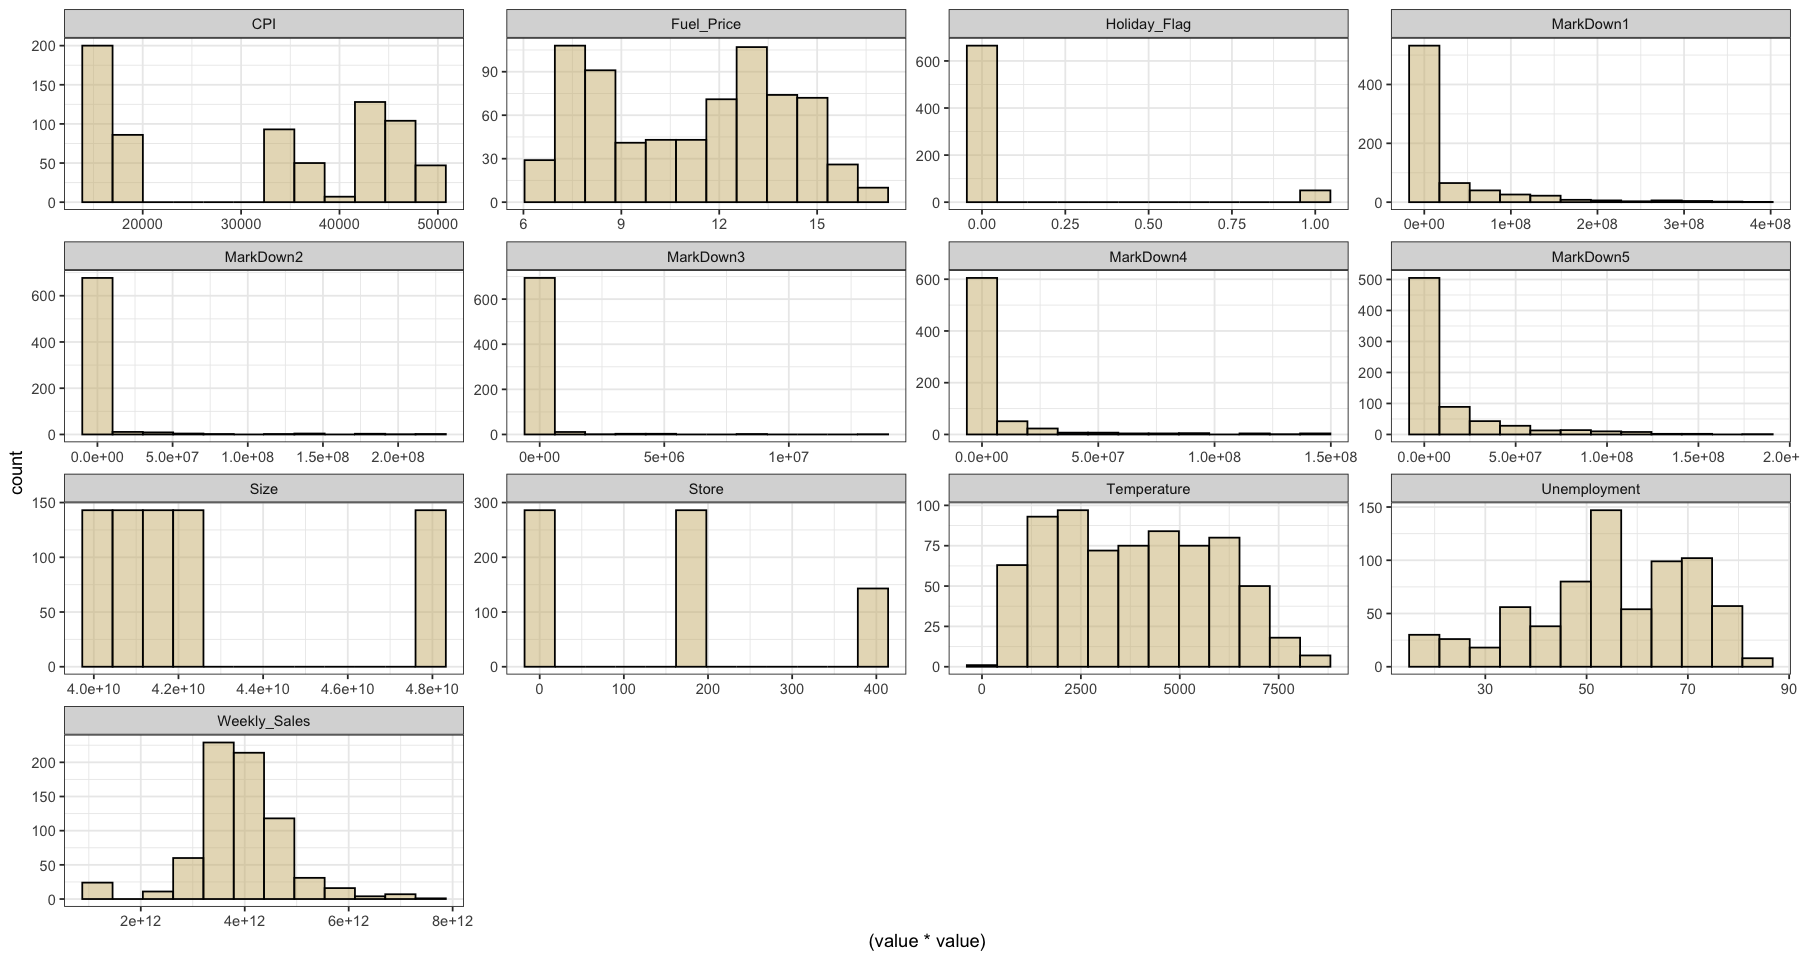

In [74]:
# Square Transformed

df %>% 
keep(is.numeric) %>%    #For choosing only numeric variables
gather()%>%             #Gathering the data
ggplot(aes((value*value)))+
facet_wrap(~key, scales="free")+
geom_histogram(bins=12, color="black", fill="#CFB87C", alpha=0.5)+
theme_bw()

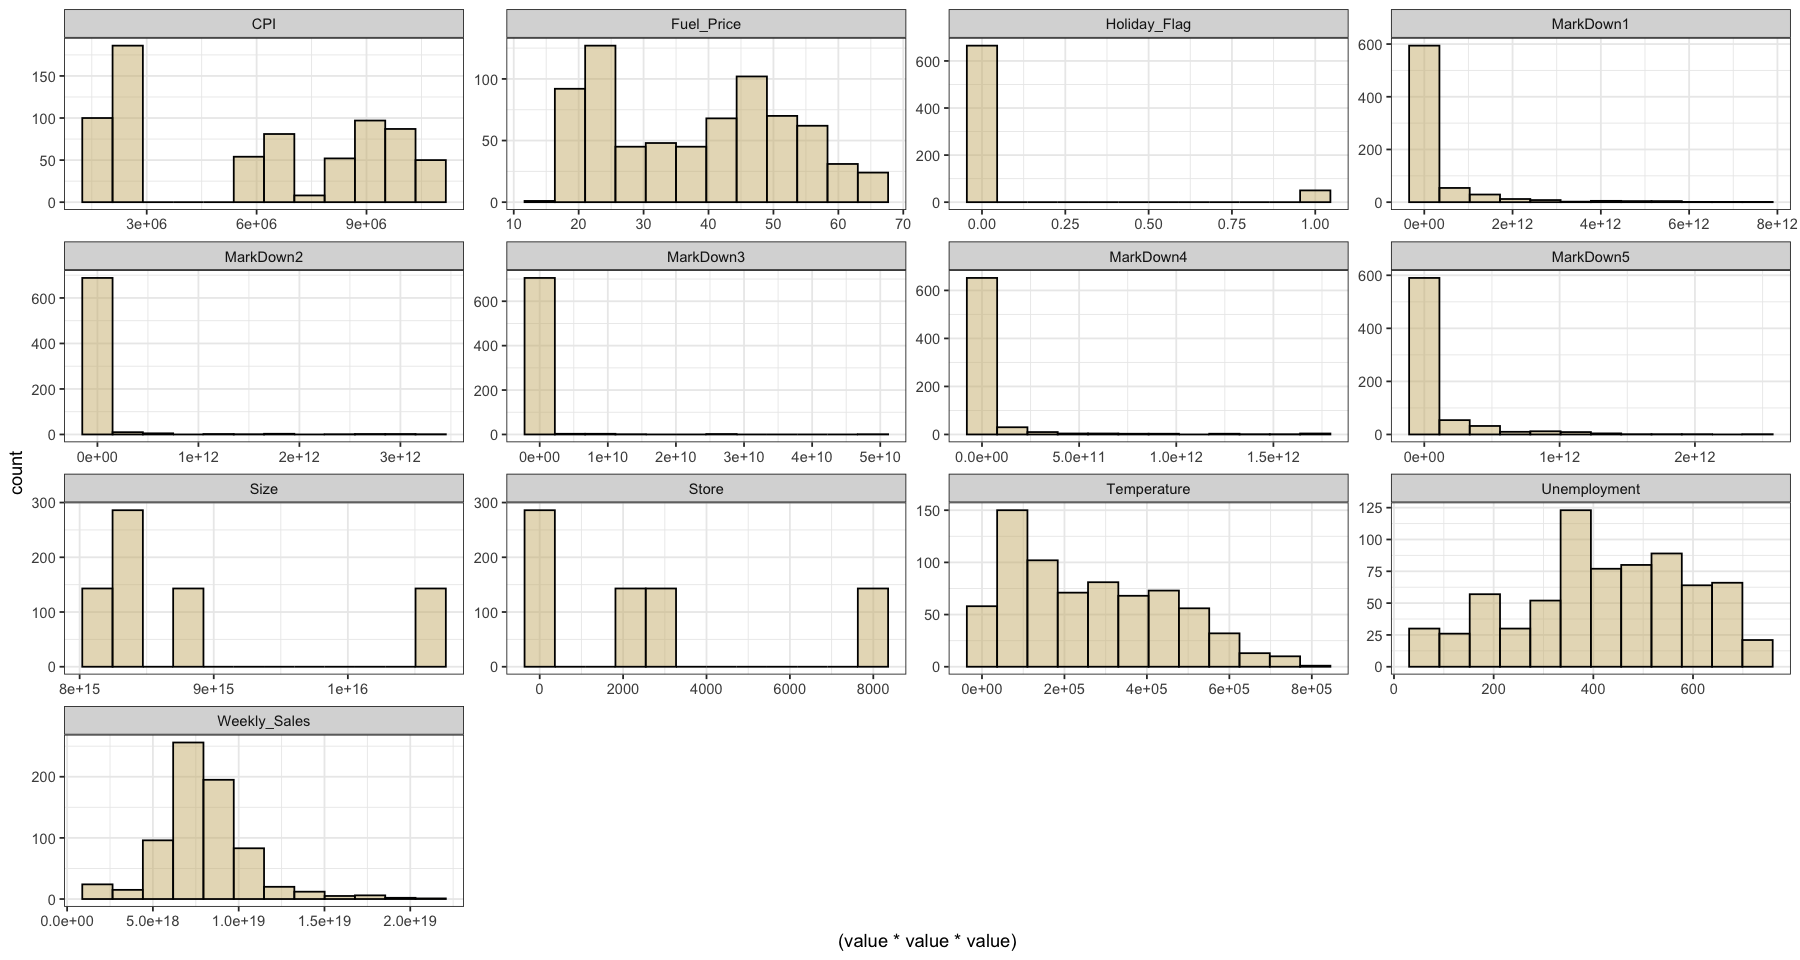

In [68]:
# Cube Transformed

df %>% 
keep(is.numeric) %>%    #For choosing only numeric variables
gather()%>%             #Gathering the data
ggplot(aes((value*value*value)))+
facet_wrap(~key, scales="free")+
geom_histogram(bins=12, color="black", fill="#CFB87C", alpha=0.5)+
theme_bw()

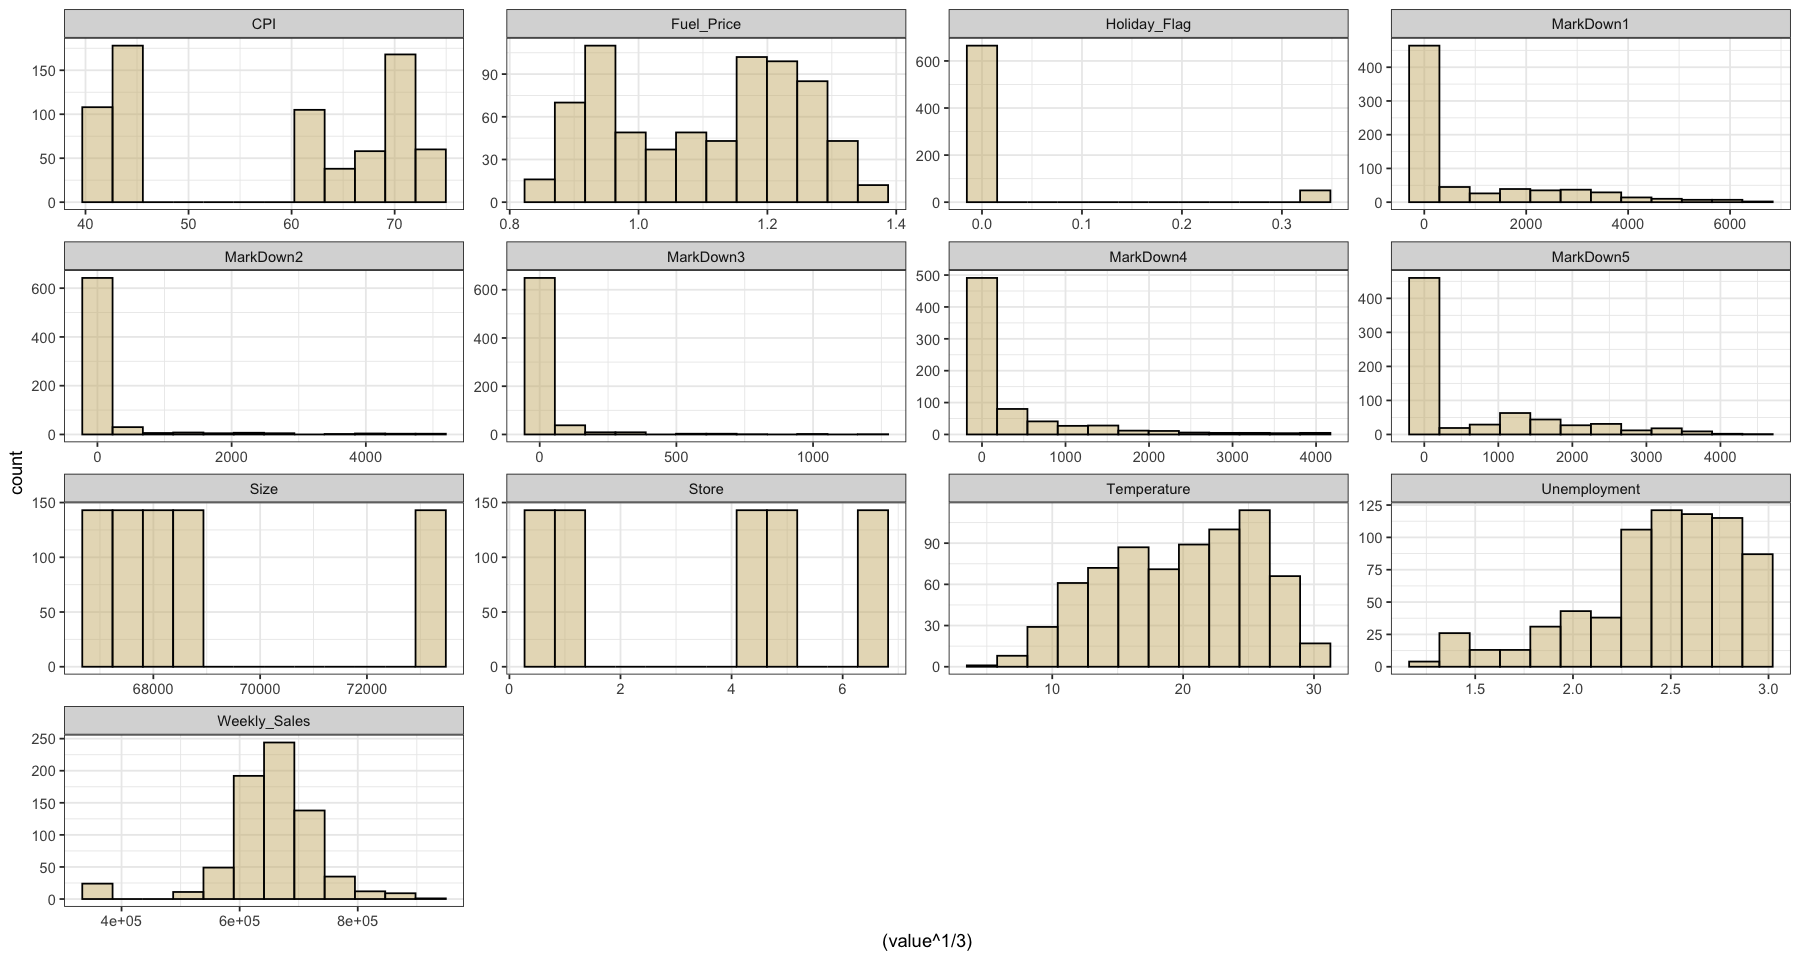

In [69]:
# Cuberoot Transformed

df %>% 
keep(is.numeric) %>%    #For choosing only numeric variables
gather()%>%             #Gathering the data
ggplot(aes((value^1/3)))+
facet_wrap(~key, scales="free")+
geom_histogram(bins=12, color="black", fill="#CFB87C", alpha=0.5)+
theme_bw()

Warning message:
“Removed 2249 rows containing non-finite values (`stat_bin()`).”


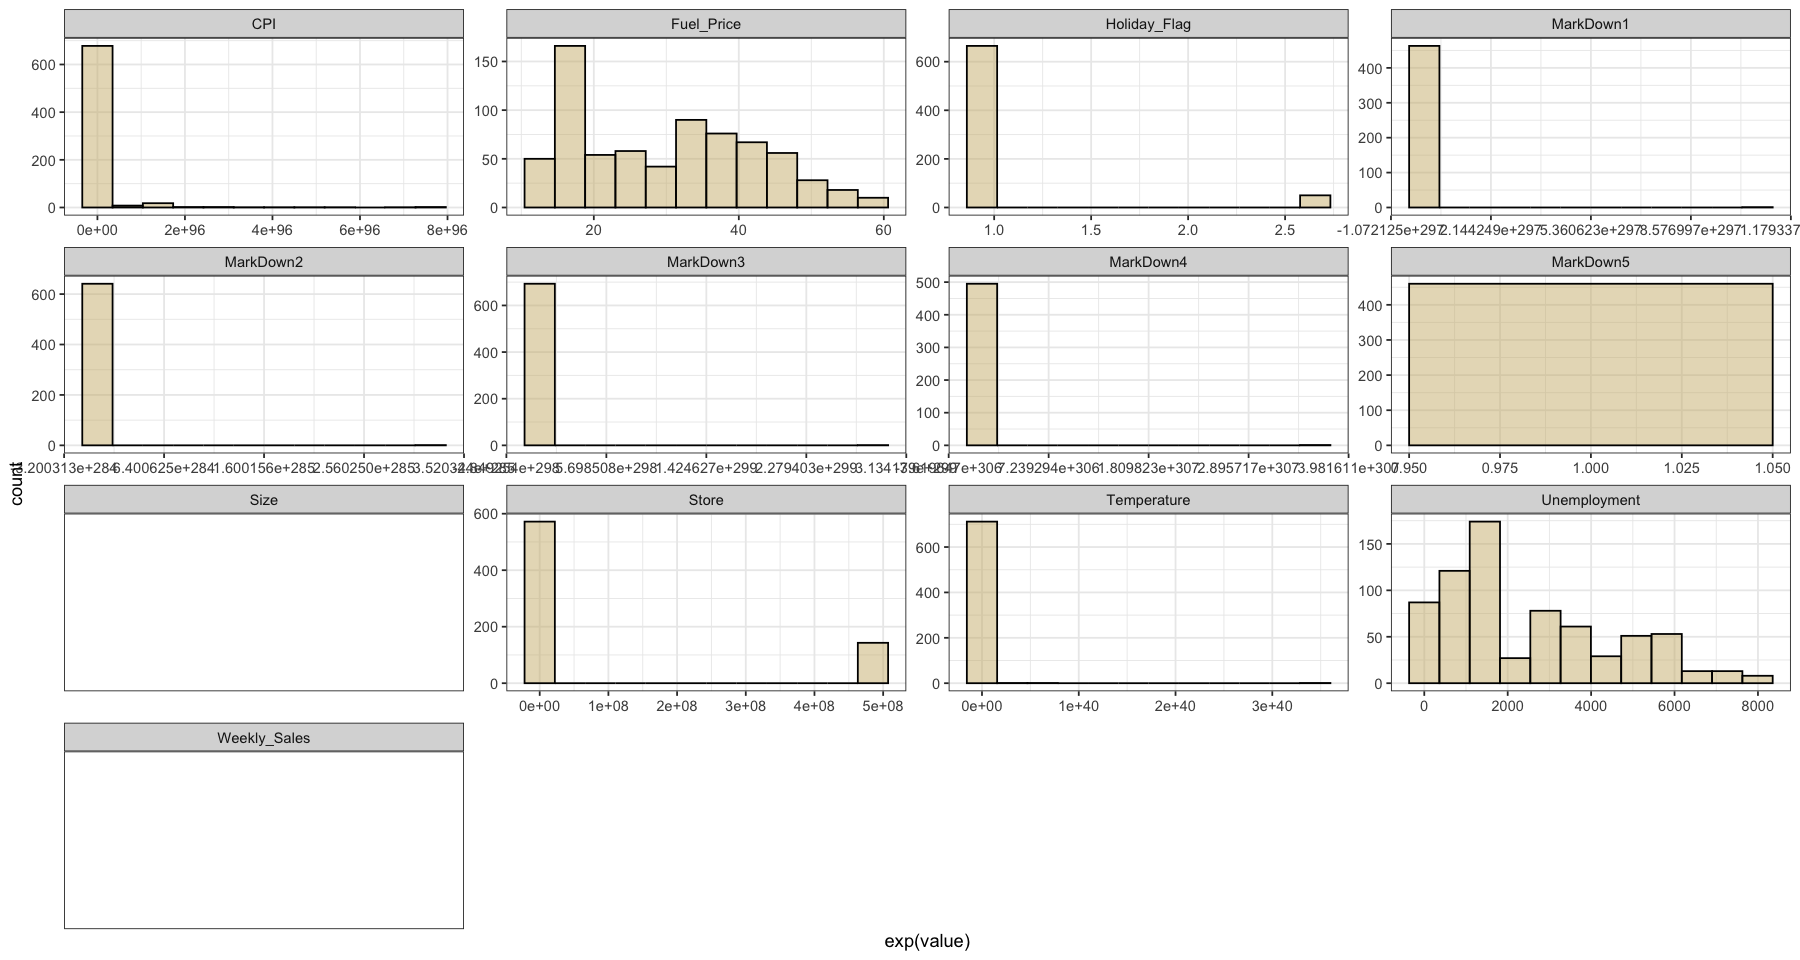

In [70]:
# Exponential Transformed

df %>% 
keep(is.numeric) %>%    #For choosing only numeric variables
gather()%>%             #Gathering the data
ggplot(aes(exp(value)))+
facet_wrap(~key, scales="free")+
geom_histogram(bins=12, color="black", fill="#CFB87C", alpha=0.5)+
theme_bw()

In [117]:
# check for normality
ks.test(df$Weekly_Sales, "pnorm", mean = mean(df$Weekly_Sales), sd = sd(df$Weekly_Sales))

Warning message in ks.test.default(df$Weekly_Sales, "pnorm", mean = mean(df$Weekly_Sales), :
“ties should not be present for the Kolmogorov-Smirnov test”



	Asymptotic one-sample Kolmogorov-Smirnov test

data:  df$Weekly_Sales
D = 0.12003, p-value = 2.26e-09
alternative hypothesis: two-sided


Reject null hypothesis that this comes from Normal distribtuion

---
----

# 6. Linear Regression Diagnostics


LIHN:
- Linearity
- Independence
- Homoskedascity
- Normality

In [158]:
# data

head(df, 3)

Store Date       Temperature Fuel_Price MarkDown1 MarkDown2 MarkDown3
1 2     2010-02-05 40.19       2.572      0         0         0        
2 2     2010-02-12 38.49       2.548      0         0         0        
3 2     2010-02-19 39.69       2.514      0         0         0        
  MarkDown4 MarkDown5 CPI      Unemployment IsHoliday Weekly_Sales Size  
1 0         0         210.7526 8.324        FALSE     2136989      202307
2 0         0         210.8980 8.324         TRUE     2137810      202307
3 0         0         210.9452 8.324        FALSE     2124452      202307
  Holiday_Flag
1 0           
2 1           
3 0

In [159]:
# Fit a linear regression model

lmod = lm(Weekly_Sales ~ 
          Temperature + Fuel_Price + MarkDown1 + MarkDown2 + MarkDown3 + MarkDown4 + MarkDown5 + 
          CPI + Unemployment + Size, data = df)

summary(lmod)


Call:
lm(formula = Weekly_Sales ~ Temperature + Fuel_Price + MarkDown1 + 
    MarkDown2 + MarkDown3 + MarkDown4 + MarkDown5 + CPI + Unemployment + 
    Size, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-953178  -95804    4476  108356  831959 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.596e+06  4.324e+05   8.317 4.65e-16 ***
Temperature   8.018e+01  5.691e+02   0.141 0.887993    
Fuel_Price   -1.300e+04  2.382e+04  -0.546 0.585548    
MarkDown1     5.552e+00  3.272e+00   1.697 0.090151 .  
MarkDown2     7.825e-01  4.883e+00   0.160 0.872729    
MarkDown3    -1.870e+02  2.993e+01  -6.247 7.23e-10 ***
MarkDown4     1.271e+01  5.600e+00   2.269 0.023553 *  
MarkDown5    -2.931e+00  4.702e+00  -0.623 0.533276    
CPI          -6.645e+02  3.665e+02  -1.813 0.070281 .  
Unemployment -3.051e+04  1.025e+04  -2.977 0.003010 ** 
Size         -6.133e+00  1.850e+00  -3.316 0.000961 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0

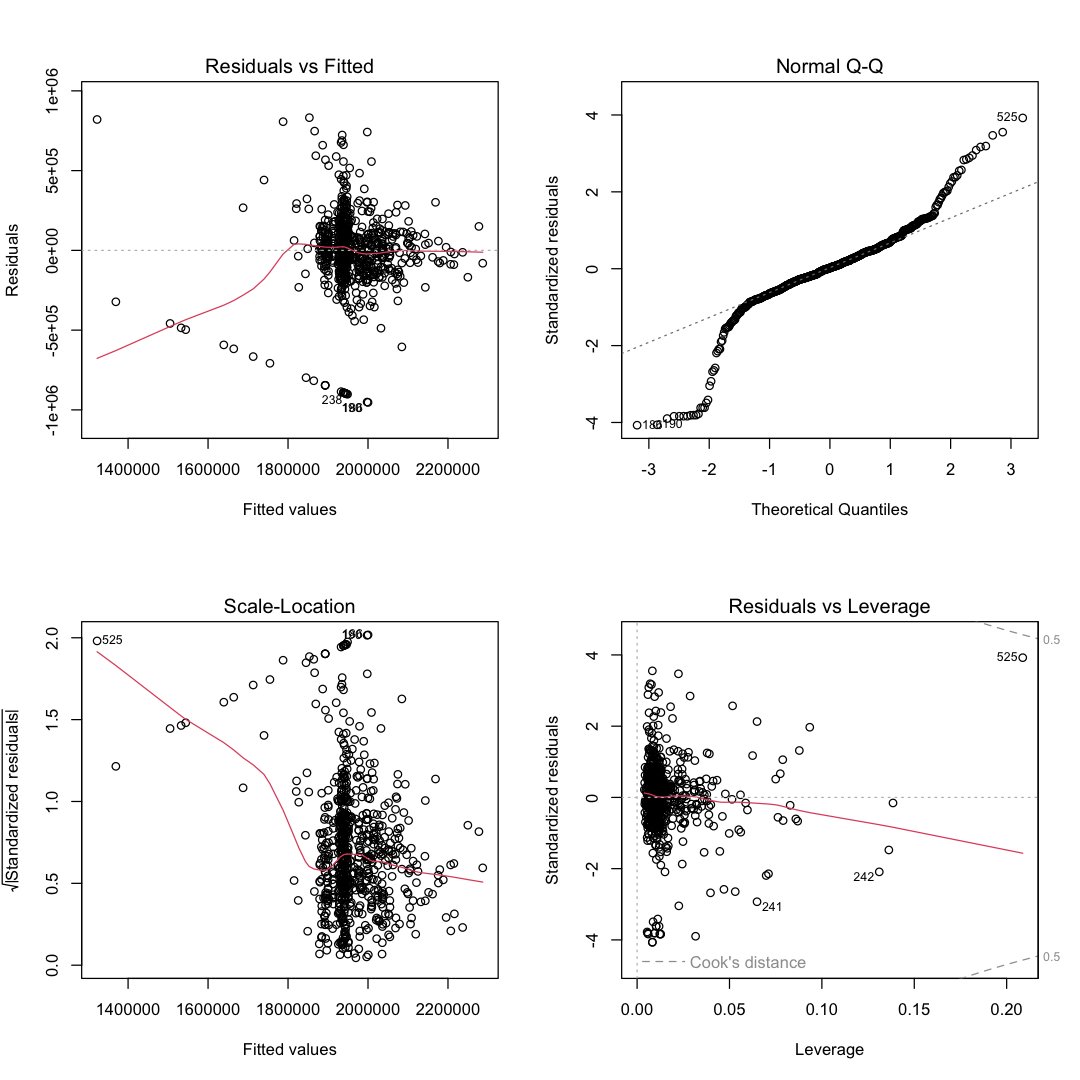

In [160]:
# Basic R Diagonostic Plots

options(repr.plot.width = 9, repr.plot.height = 9)
par(mfrow = c(2,2))

plot(lmod)

In [183]:
# just to simplify loading these attributes later-on

df.diagnostics = data.frame(Date=df$Date,
                            Temperature = df$Temperature, 
                            Fuel_Price = df$Fuel_Price,
                            MarkDown1 = df$MarkDown1,
                            MarkDown2 = df$MarkDown2,
                            MarkDown3 = df$MarkDown3,
                            MarkDown4 = df$MarkDown4,
                            MarkDown5 = df$MarkDown5,
                            CPI = df$CPI,
                            Unemployment = df$Unemployment,
                            Size = df$Size,
                            y = df$Weekly_Sales,             # Response
                            yhat = fitted(lmod),             # Predicted
                            r = resid(lmod))                 # Residual (y - y^)
#df.diagnostics[1:3,]

## 1. Violation of Linearity Assumption

Diagnosis:

- Fitted vs Observed Plot
- Residuals vs Fitted Plot

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


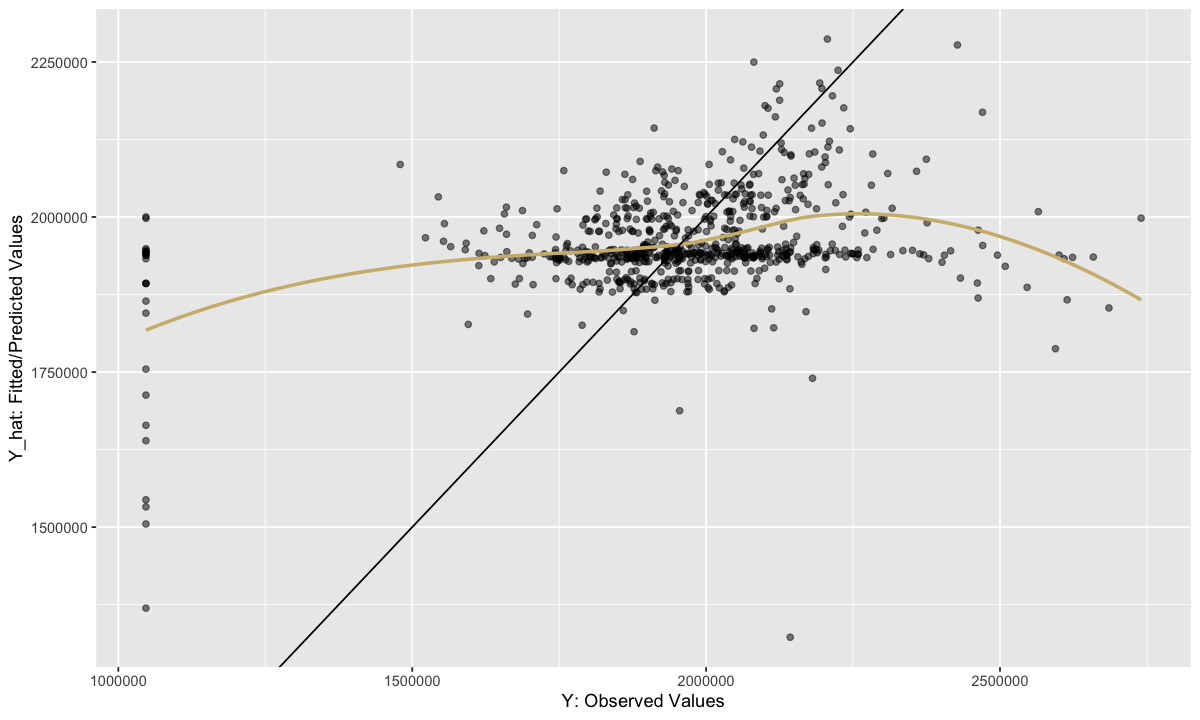

In [184]:
## Predicted/Fitted vs Observed Plot

options(repr.plot.width=10, repr.plot.height=6)
ggplot(df.diagnostics, aes(x=y, y=yhat)) + 
    geom_point(alpha = 0.5) + 
    geom_smooth(se=F, col="#CFB87C") + 
    geom_abline(intercept=0, slope=1) +
    xlab("Y: Observed Values") + 
    ylab("Y_hat: Fitted/Predicted Values")

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


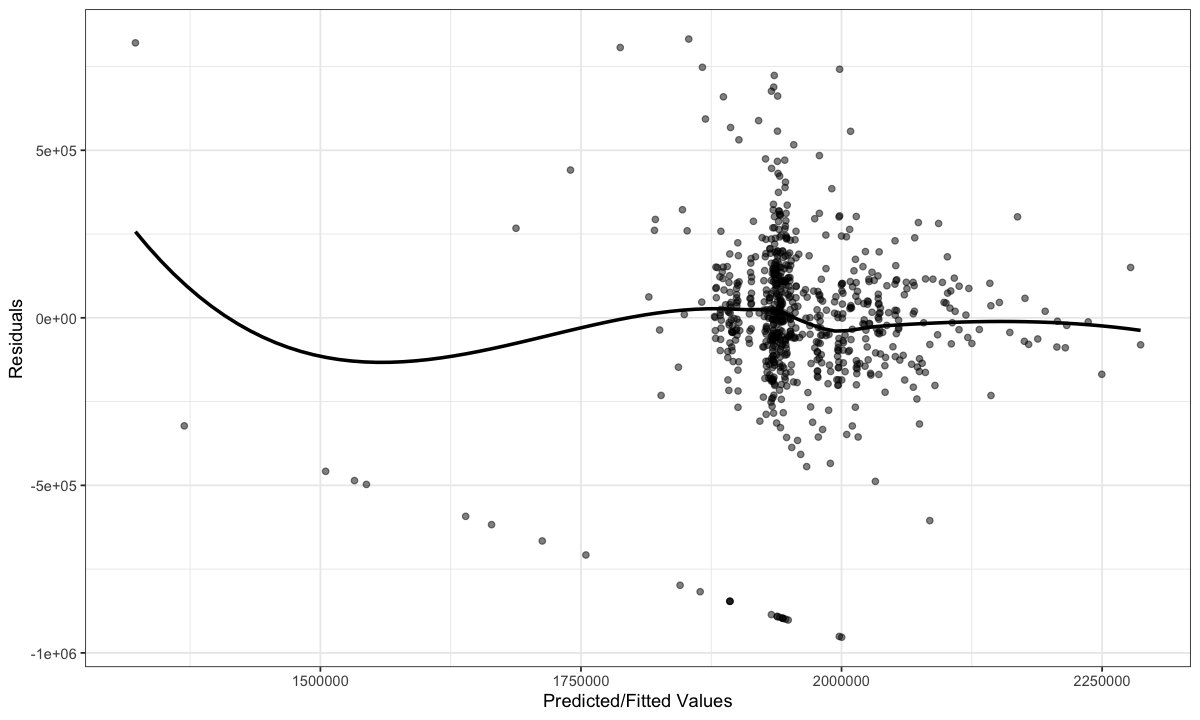

In [185]:
## Residuals vs Fitted Plot

ggplot(df.diagnostics, aes(x=yhat, y=r)) +
  geom_point(alpha = 0.5) + 
  geom_smooth(se=F, col = 'black') + 
  xlab("Predicted/Fitted Values") + 
  ylab("Residuals") + 
  theme_bw()

Linearity assumption is violated!

## 2. Violation of Independence Assumption

Note that the data doesn’t provide us with any natural ordering, e.g., time or distance measurements. So, we need to sort the values based on any one of the features, and then use index.

Diagnosis:

- Residual vs Ordered Index plot
- Successive Residuals plot
- Durbin-Watson Hypothesis Testing

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


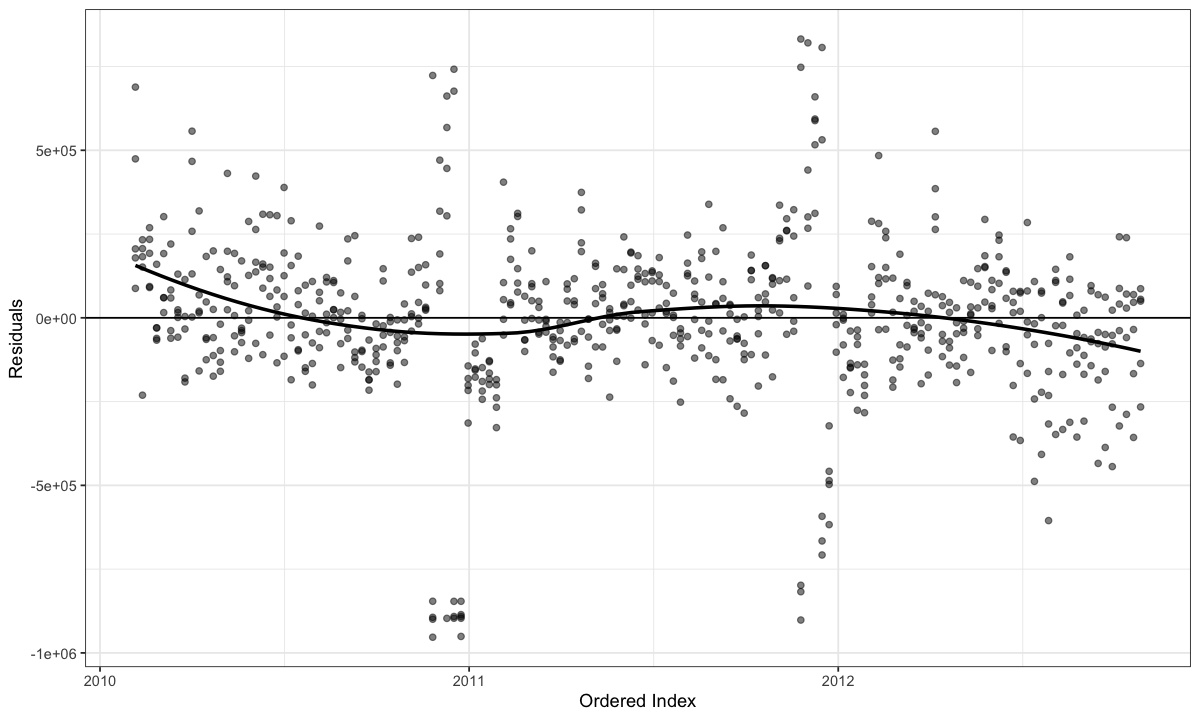

In [188]:
## Residual vs Ordered Index plot

ggplot(df.diagnostics, aes(df.diagnostics$Date, y=r)) + 
  geom_point(alpha = 0.5) + 
  geom_abline(slope = 0, intercept = 0) +
  geom_smooth(se = F, col = 'black') +
  xlab("Ordered Index") +
  ylab("Residuals") + 
  theme_bw()

Correlation between two successive error terms:  0.2460717

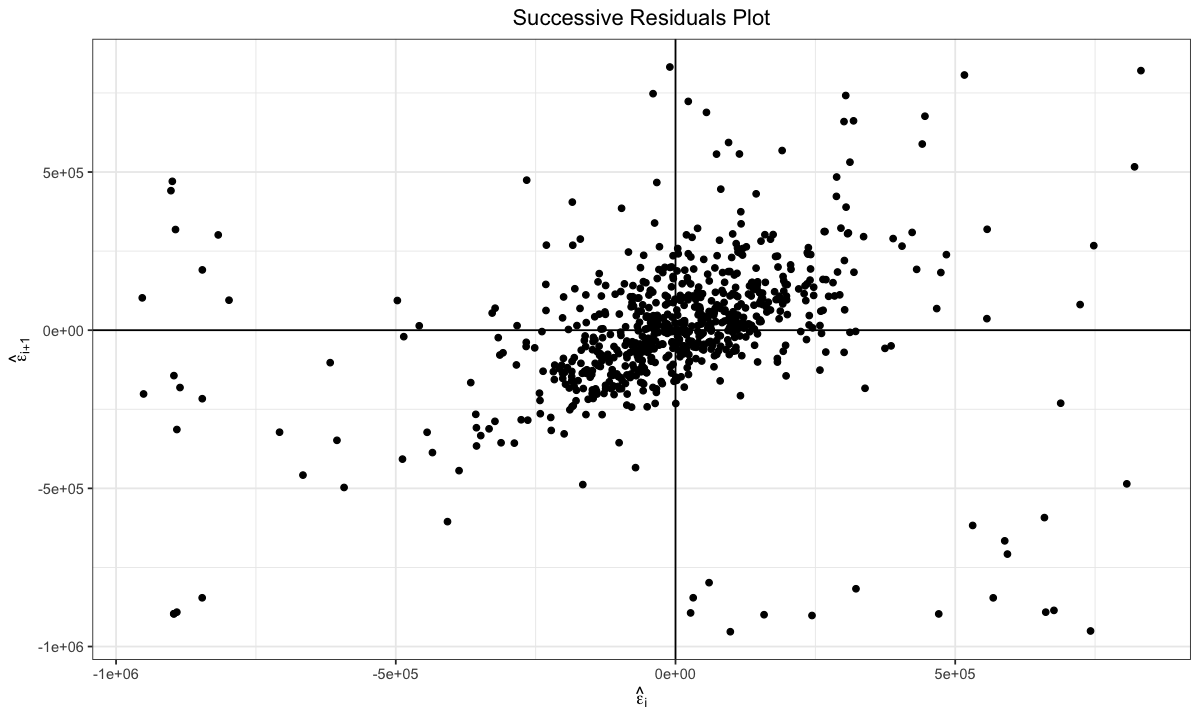

In [189]:
# size
n = dim(df)[1]; 

# Succfessive Error terms (residuals)
e1 = head(df.diagnostics$r, n-1)
e2 = tail(df.diagnostics$r, n-1)
cat("Correlation between two successive error terms: ", cor(e1, e2))

srp = data.frame(e1, e2)
ggplot(srp, aes(x = e1, y = e2)) + 
    geom_point() + 
    geom_vline(xintercept = 0) + 
    geom_hline(yintercept = 0) + 
    xlab(expression(hat(epsilon)[i])) +
    ylab(expression(hat(epsilon)[i+1])) + 
    ggtitle("Successive Residuals Plot") + 
    theme_bw() + 
    theme(plot.title = element_text(hjust = 0.5)) 

Independence assumption is violated based on first plot!

## 3. Violation of Homoscedasticity Assumption (constant variance)

Non constant variance assumption test.


Diagnosis:

- Residuals vs Fitted/Predicted Plot
- Breusch-Pagan Test

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


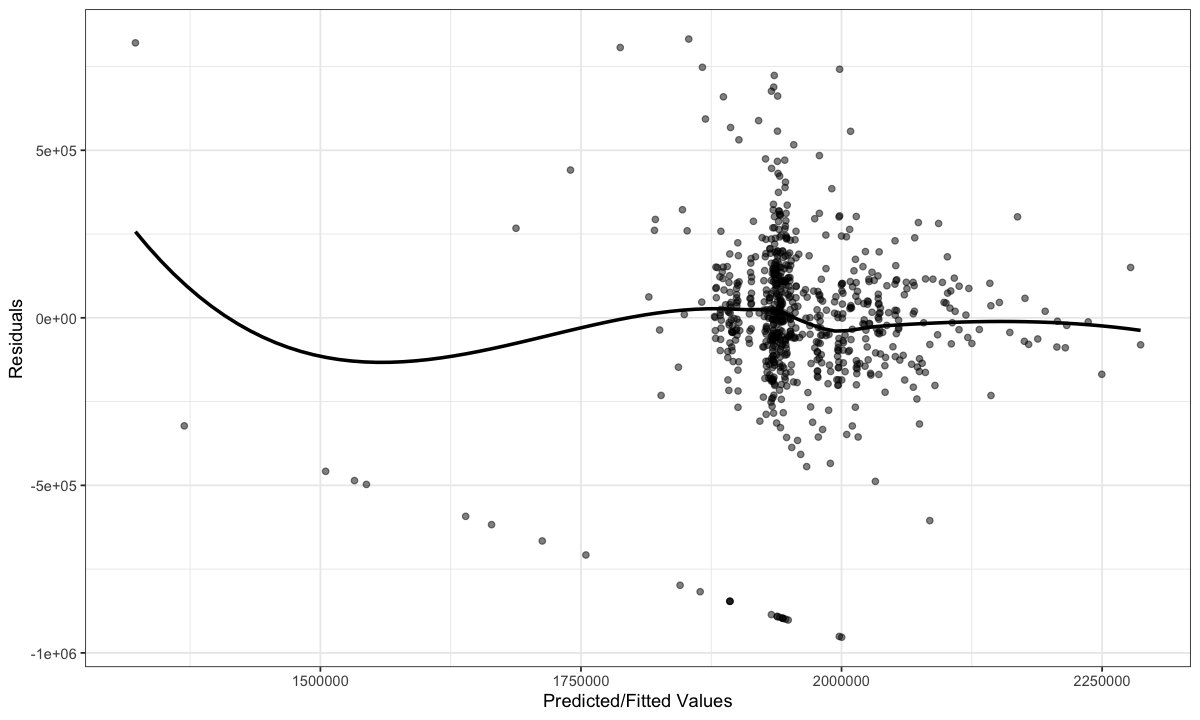

In [190]:
## Residuals vs Fitted Plot

ggplot(df.diagnostics, aes(x=yhat, y=r)) +
  geom_point(alpha = 0.5) + 
  geom_smooth(se=F, col = 'black') + 
  xlab("Predicted/Fitted Values") + 
  ylab("Residuals") + 
  theme_bw()

heteroscedasticity can be seen!

In [191]:
## Breusch-Pagan Test

# install.packages("lmtest")
library(lmtest)

# perform Breusch-Pagan test
bptest(lmod)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric





	studentized Breusch-Pagan test

data:  lmod
BP = 111.74, df = 10, p-value < 2.2e-16


The Breusch-Pagan test uses the following null and alternative hypotheses:

- $H_o$ : Homoscedasticity is present (the residuals are distributed with constant variance)
- $H_a$ : Homoscedasticity is absent, i.e. Heteroscedasticity is present



As per the Breusch-Pagan Test, the p-value is 0.1623, which is greater than $\alpha$ level of significance.  Thus we fail to reject the Null Hypothesis, and thus Homoscedasticity is present!


.


Constant Variance assumption is violated!!

.

## 4. Violation of Normality Assumption

Whether error term follows a normal distribution or not?


Diagnosis:
- QQ Plot - Residual Quantiles vs Theoretical Normal Distribution Quantiles Plot

- Residuals vs Fitted Plot

- Shapiro-Wilk Test

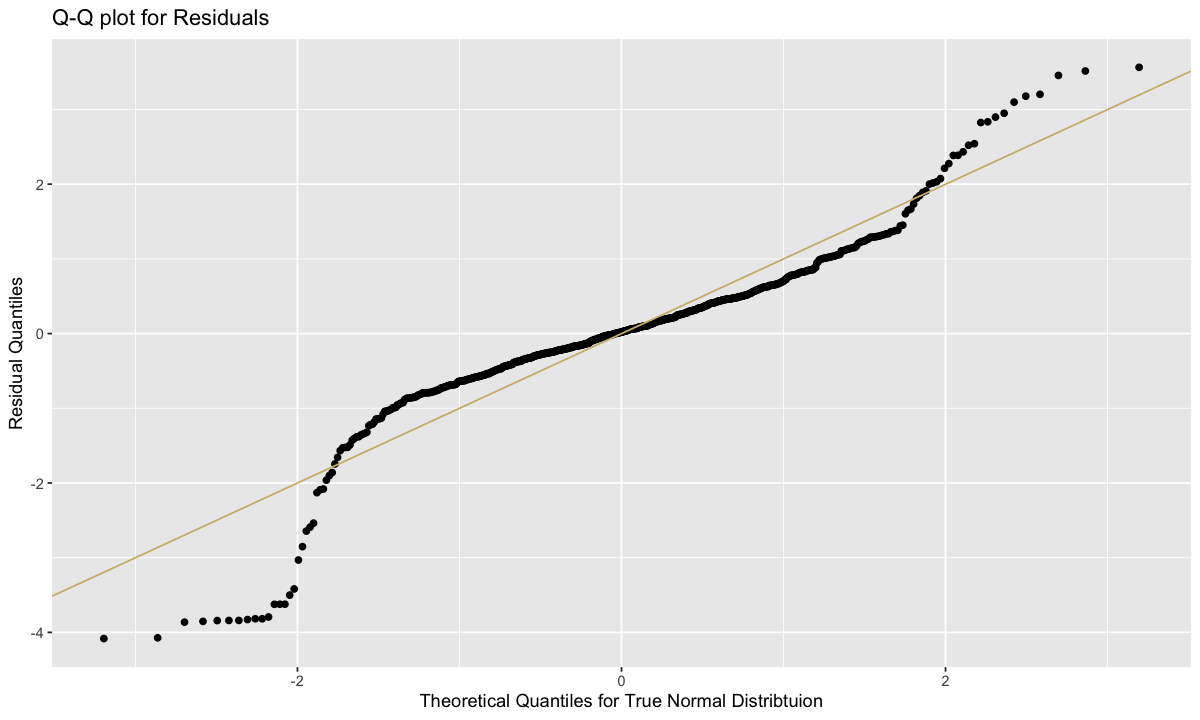

In [192]:
# QQ: Quantile Residuals - Quantiles True Normal Plot

ggplot(df.diagnostics, aes(sample = (r - mean(r))/sd(r) )) +
  stat_qq() + 
  geom_abline(slope = 1, intercept = 0, col="#CFB87C") +
  xlab("Theoretical Quantiles for True Normal Distribtuion") + 
  ylab("Residual Quantiles") + 
  ggtitle("Q-Q plot for Residuals")

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


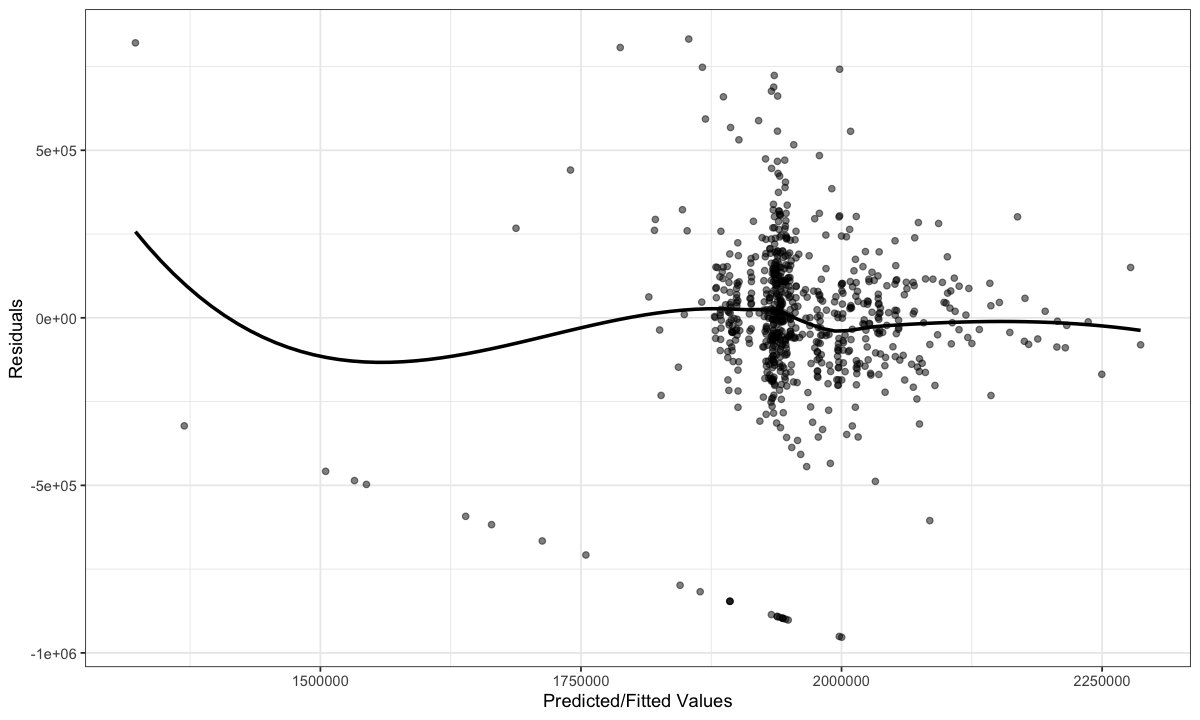

In [193]:
## Residuals vs Fitted Plot

ggplot(df.diagnostics, aes(x=yhat, y=r)) +
  geom_point(alpha = 0.5) + 
  geom_smooth(se=F, col = 'black') + 
  xlab("Predicted/Fitted Values") + 
  ylab("Residuals") + 
  theme_bw()

### Shapiro Wilk Test


The Shapiro-Wilk’s test or Shapiro test is a normality test in frequentist statistics. The null hypothesis of Shapiro’s test is that the population is distributed normally. If the value of p is equal to or less than 0.05, then the hypothesis of normality will be rejected by the Shapiro test. On failing, the test can state that the data will not fit the distribution normally with 95% confidence. However, on passing, the test can state that there exists no significant departure from normality. This test can be done very easily in R programming.


$W=\frac{(\sum_{i=1}^n a_ix_{(i)})^2}{(\sum_{i=1}^n x_i - \bar{x})^2}$

where,

- x(i) : it is the ith smallest number in the given sample.
- mean(x) : ( x1+x2+……+xn) / n i.e the sample mean.
- ai : coefficient that can be calculated as (a1,a2,….,an) = (mT V-1)/C . 

Here V is the covariance matrix, m and C are the vector norms that can be calculated as C= || V-1 m || and m = (m1, m2,……, mn ).


###### Hypothesis:

$H_o:$ Samples residuals came from a normal distribution.

$H_a:$ Samples residuals did not came from a normal distribution.

In [196]:
# Shapiro test of Normality

# loading the package
library("dplyr")

# Using the shapiro.test() to check
shapiro.test(df$Weekly_Sales)


	Shapiro-Wilk normality test

data:  df$Weekly_Sales
W = 0.87531, p-value < 2.2e-16


- For all three features, the p-value is small and less than the alpha, thus we reject the Null hypothesis which stated these samples came from a normal distribution. 


- Thus, the hypothesis of normality is rejected by the Shapiro test.


.

Normality assumption is violated!

.

### All assumptions are clearly violated! LR cannot be preformed on time-series data!

----
----